<a href="https://colab.research.google.com/github/kittisaktaoma/GO-tools-comparsion/blob/master/GO_tools_Comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and prepare package

In [376]:
install.packages("ComplexHeatmap", dependencies=TRUE, repos='http://cran.rstudio.com/')

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘ComplexHeatmap’ is not available (for R version 3.6.3)”


In [ ]:
install.packages(c("data.table","factoextra"))
install.packages(c("Himsc")) 
install.packages(c("ComplexHeatmap")) 
install.packages(c("klaR","splitstackshape"))
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
library(devtools)
install_github("omegahat/XML")
install_github("harrelfe/Hmisc")
#install_github("jokergoo/ComplexHeatmap")
BiocManager::install("GSEABase")
BiocManager::install("GO.db")
install.packages("pheatmap")
install.packages("irr")
install.packages("dendextend")
install.packages("extrafont")

In [ ]:
library(dendextend)
library(ggplot2)
library(data.table)
library(factoextra)
library(dplyr)
library(data.table)
library(corrplot)
library(RColorBrewer)
library(Hmisc)
library(ggrepel)
#library(ComplexHeatmap)
library(devtools)
library(ggpubr)
library(reshape2)
library(klaR)
library(purrr)
library(splitstackshape)
library(broom)
library(circlize)
library(GSEABase)
library(GO.db)
library(rstatix)
library(tidyverse)
library(irr)
library(extrafont)
font_import()
#library(FSA)

In [4]:
font_custom <-   theme(text = element_text(size=16,family = 'Arial'),
                    axis.text.y   = element_text(size=16,family = 'Arial',color="black"),
                    axis.text.x = element_text(size = 16,angle = 90, hjust = 1,family = 'Arial',color="black"),
                    axis.title.y  = element_text(size=16,family = 'Arial',color="black"),
                    axis.title.x  = element_text(size=16,family = 'Arial',color="black"),
                    strip.text.x = element_text(size = 16,family = 'Arial',color="black"),
                    strip.text.y = element_text(size = 16,family = 'Arial',color="black"),
                    legend.title=element_text(size=16,family = 'Arial'), 
                    legend.text=element_text(size=16,family = 'Arial'))

font_custom.02 <-   theme(text = element_text(size=16,family = 'Arial'),
                    axis.text.y   = element_text(size=16,family = 'Arial',color="black"),
                    axis.text.x = element_text(size = 16,family = 'Arial',color="black"),
                    axis.title.y  = element_text(size=16,family = 'Arial',color="black"),
                    axis.title.x  = element_text(size=16,family = 'Arial',color="black"),
                    strip.text.x = element_text(size = 16,family = 'Arial',color="black"),
                    strip.text.y = element_text(size = 16,family = 'Arial',color="black"),
                    legend.title=element_text(size=16,family = 'Arial'), 
                    legend.text=element_text(size=16,family = 'Arial'))

# **SEA characteristics of 10 GO annotation and enrichment analysis tools** 

## Binary Heatmap

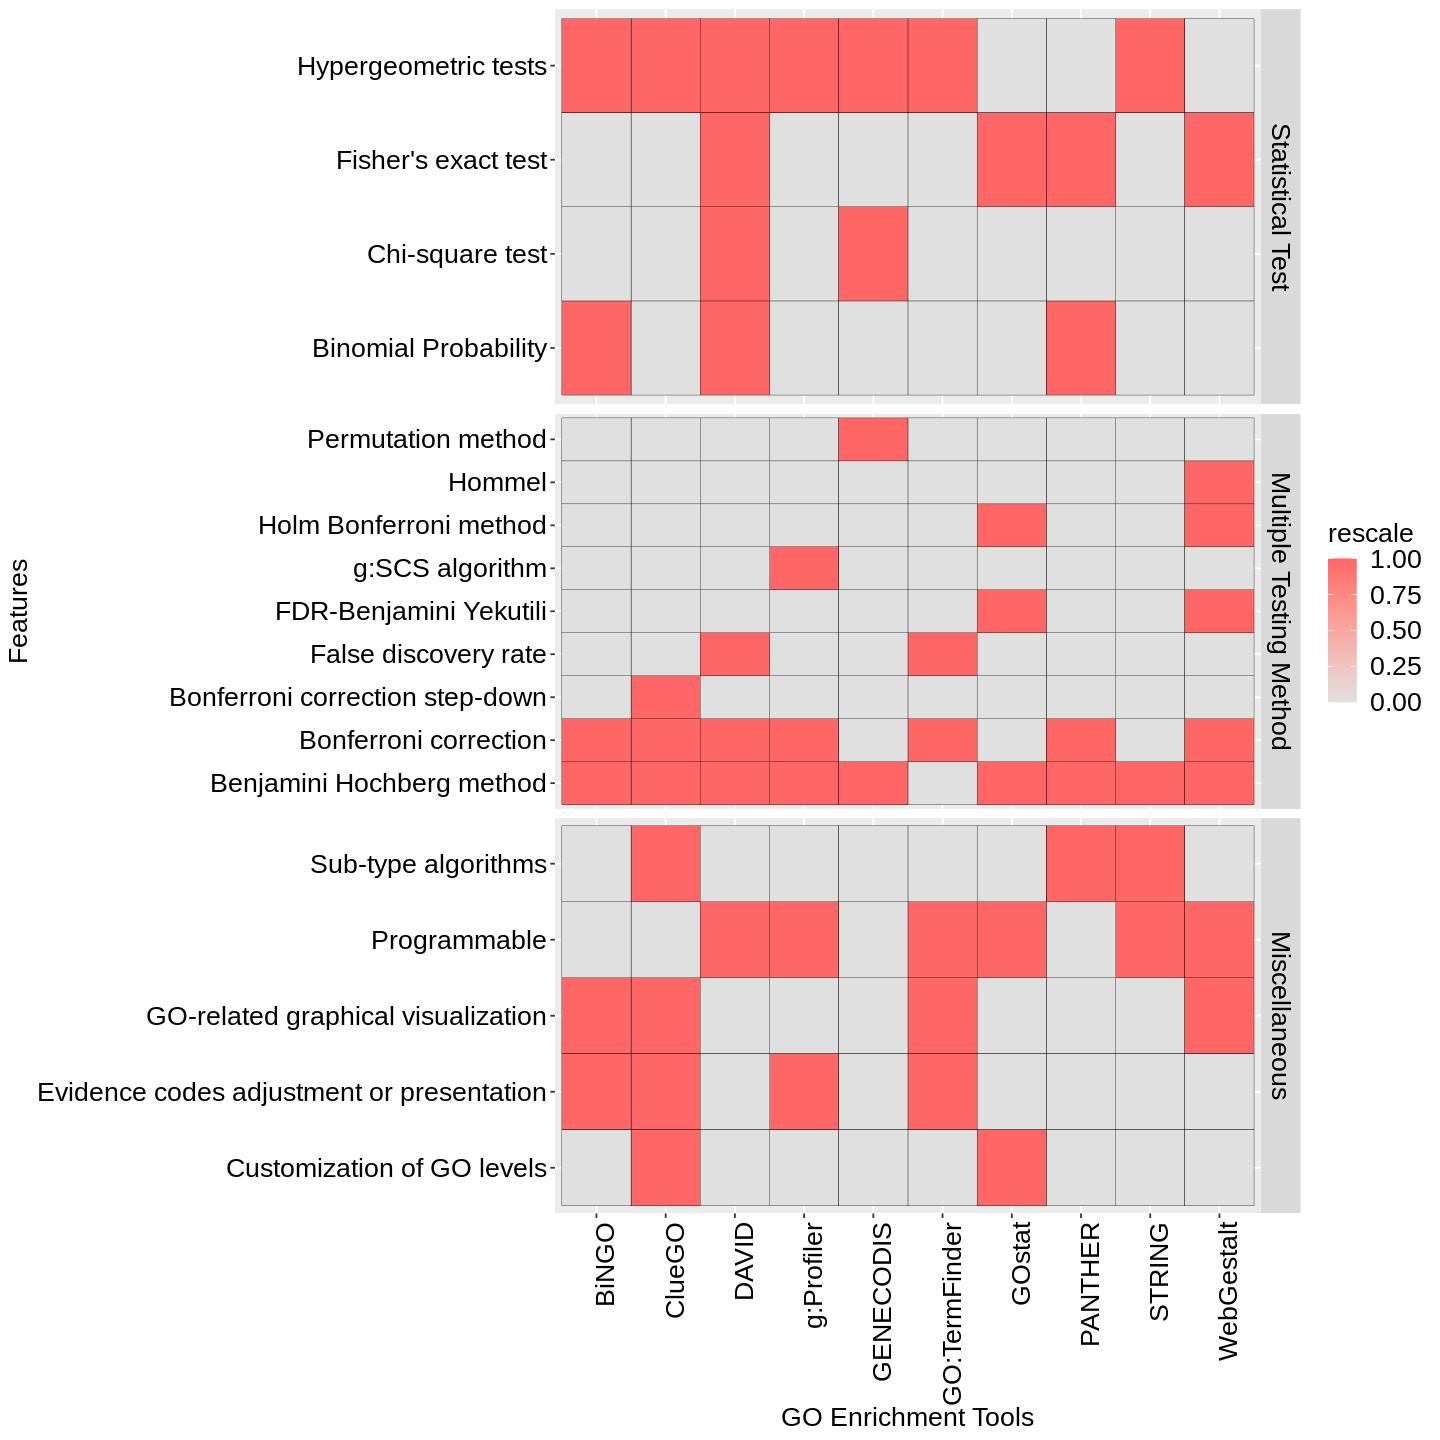

In [ ]:
# Characteristics 
df1.m <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Characteristics.txt")
df1.m$type <- factor(df1.m$type, levels = c("Statistical Test","Multiple Testing Method","Miscellaneous"))
# Make plots wider 
options(repr.plot.width=12, repr.plot.height=12)
ggplot(df1.m, aes(x=Database, y=variable)) +
  geom_tile(aes(fill = rescale), colour = "black") +
  scale_fill_gradient(low = "#E0E0E0", high = "#FF6666") +
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  labs(colors = "") +theme(axis.text=element_text(size=12)) +
  ylab("Features") +
  xlab("GO Enrichment Tools") +
  facet_grid(type ~ .,scales = "free") + font_custom

## K-mean clustering

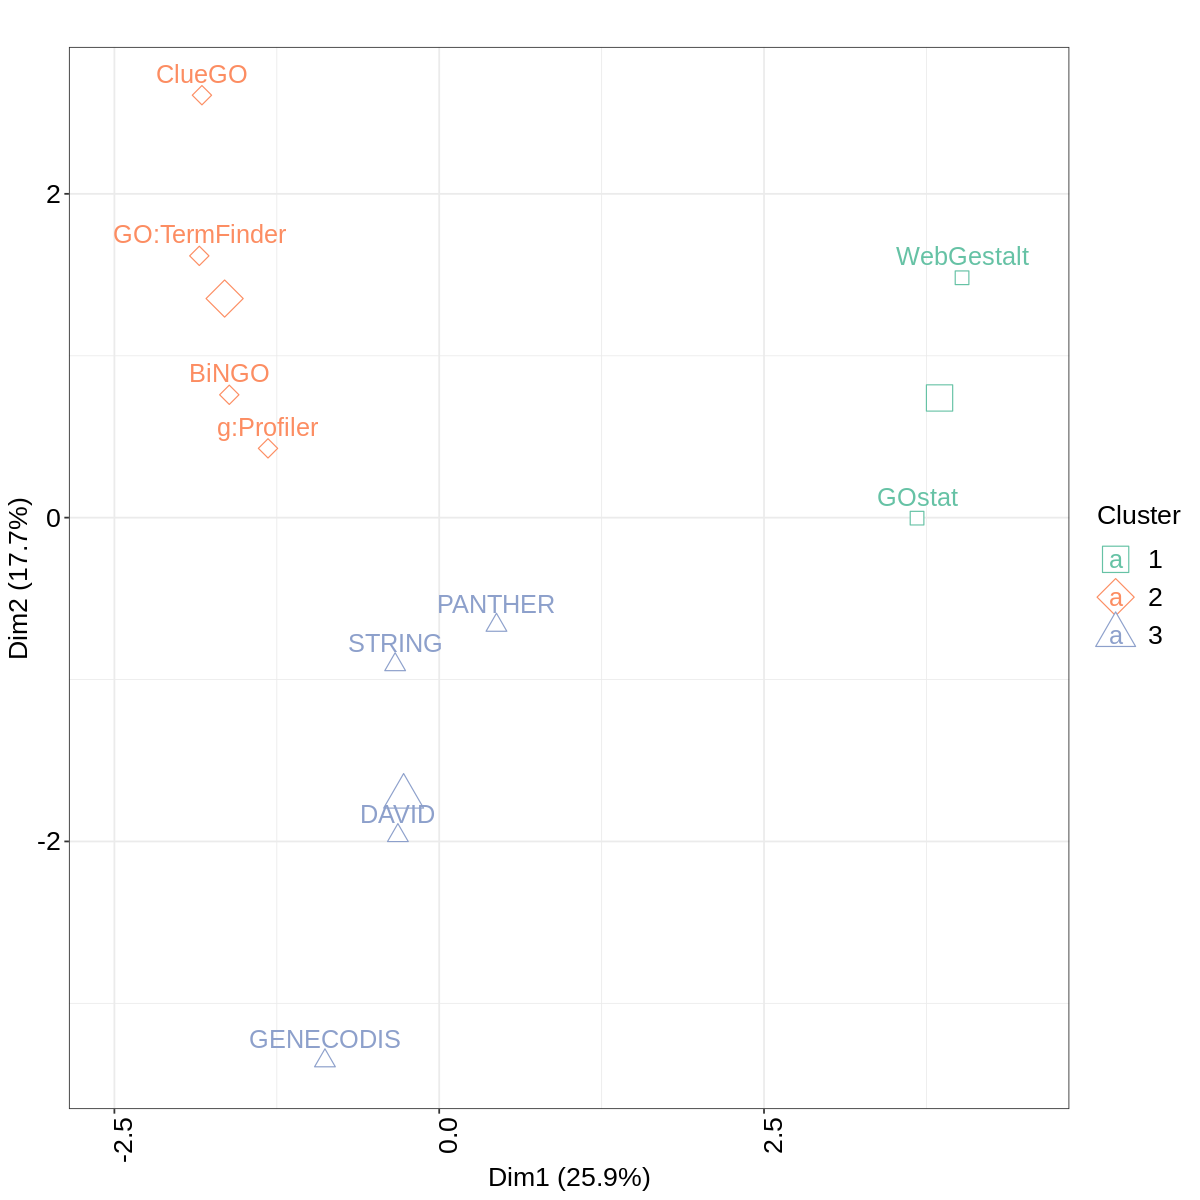

In [ ]:
set.seed(123)
kdf <-  fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Tools_Properties_Binary.csv") %>% as.data.frame()
df.01 <- kdf[,-1]
rownames(df.01) <- kdf[,1]

# function to compute total within-cluster sum of square 
wss <- function(k) {
  kmeans(df, k, nstart = 20 )$tot.withinss
}

# Compute and plot wss for k = 1 to k = 15
k.values <- 1:8

# extract wss for 2-15 clusters
wss_values <- map_dbl(k.values, wss)

#plot(k.values, wss_values,
#     type="b", pch = 19, frame = FALSE, 
#    xlab="Number of clusters K",
#    ylab="Total within-clusters sum of squares")


final <- kmeans(df.01, 3, nstart = 50,iter.max = 100)

# Make plots wider 
options(repr.plot.width=10, repr.plot.height=10)
fviz_cluster(final, data = df.01,labelsize = 16,ellipse = F,show.clust.cent = T,
pointsize = 4,ggtheme = theme_bw()) +
  theme_bw() +
  xlim(-2.5,4.5)  +
  scale_color_brewer('Cluster', palette='Set2') + 
  scale_fill_brewer('Cluster', palette='Set2') +
  scale_shape_manual('Cluster', values=c(22,23,24)) + 
  ggtitle(label='')+font_custom

# **The proportion of identified GO term in three categories**


In [193]:
df_01 <- read.csv("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt",sep="\t")
head(df_01)

,gene,id,fdr,ref,des,type,dataset,database,condition
,<fct>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>
1,YWHAG,GO:0008426,0.00475653,18483,protein kinase C inhibitor activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
2,HSPB1,GO:0008426,0.00475653,18483,protein kinase C inhibitor activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
3,GPI,GO:0004347,0.04792210,18483,glucose-6-phosphate isomerase activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
4,UBE2I,GO:0061656,0.04792210,18483,SUMO conjugating enzyme activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
5,CAV1,GO:0070320,0.04792210,18483,inward rectifier potassium channel inhibitor activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
6,CCT8,GO:1904851,0.04075850,18883,positive regulation of establishment of protein localization to telomere,Biological Process,Caffeine Dataset,GENECODIS,Unique


## Plot Frequency of BP, MF, CC between Caffeine and EGCG (Sig. Only)

In [33]:
round_df <- function(df, digits, rf="round") {
  
  if(  missing(df) ){  
    stop("df not set", call. = F) 
  }else if(!is.data.frame(df)){
    stop("df must be a dataframe", call.=F)
  }
  
  if(missing(digits)){
    digits <- 0
  }else if(!is.numeric( digits )){
    stop( "'digits' must be numeric", call.=F)
  }else if(length(digits)!=1){
    stop("length of 'digits' must be 1", call.=F)
  }else if(! digits > -10 | ! digits <= 10){
    stop("'digits' must be a number between -10 and 10", call.=F)
  }
  
  if(!is.character( rf )){
    stop( "'rf' must be character", call.=F)
  }else if(length(rf)!=1){
    stop("Length of 'rf' must be 1", call.=F)
  }else if(! rf %in% c('round', 'ceiling', 'floor', 'trunc', 'signif') ){ 
  stop("'rf' must be equal to 'round', 'ceiling', 'trunc', 'floor' or 'signif' ", call. = F) 
  }
  
  numeric_columns <- sapply(df, class) == 'numeric'
  
  if(rf=="round"){
  
  df[numeric_columns] <-  round(df[numeric_columns], digits)
  
  }else if(rf=="ceiling"){
    
    df[numeric_columns] <-  ceiling(df[numeric_columns])
    
  }else if(rf=="floor"){
    
    df[numeric_columns] <-  floor(df[numeric_columns])
    
  }else if(rf=="trunc"){
    
    df[numeric_columns] <-  ceiling(df[numeric_columns])
    
  }else if(rf=="signif"){
    
    df[numeric_columns] <-  signif(df[numeric_columns], digits)
    
  }
  
  df
}

In [ ]:
count_02 <-df_01[,-1] %>% unique() %>% group_by(database,dataset,type) %>% dplyr::summarise(count=n()) %>% as.data.frame() 
resh <- reshape(count_02, idvar = c("database","dataset"), timevar = "type", direction = "wide")
resh.01 <-resh[order(resh$dataset),]
names(resh.01) <- c("GO enrichment tools",
                    "Dataset",
                    "Biological process",
                   "Cellular component",
                   "Molecular function")

resh.02 <- cbind(resh.01[,c(1,2)], prop.table(as.matrix(resh.01[,-c(1,2)]), margin = 1))
resh.02[,c(3:5)] <- round_df(resh.02[,c(3:5)], digits=2)

all_non <- cbind(resh.01,resh.02)[,-c(6,7)] 
all_non$`Biological process` <- paste0(all_non$`Biological process`," ","(",all_non$`Biological process.1`,"%",")")
all_non$`Cellular component` <- paste0(all_non$`Cellular component`," ","(",all_non$`Cellular component.1`,"%",")")
all_non$`Molecular function` <- paste0(all_non$`Molecular function`," ","(",all_non$`Molecular function.1`,"%",")")

all_non.final <- all_non[,-c(6,7,8)]
ggtexttable(all_non.final, rows = NULL, theme = ttheme("classic"))


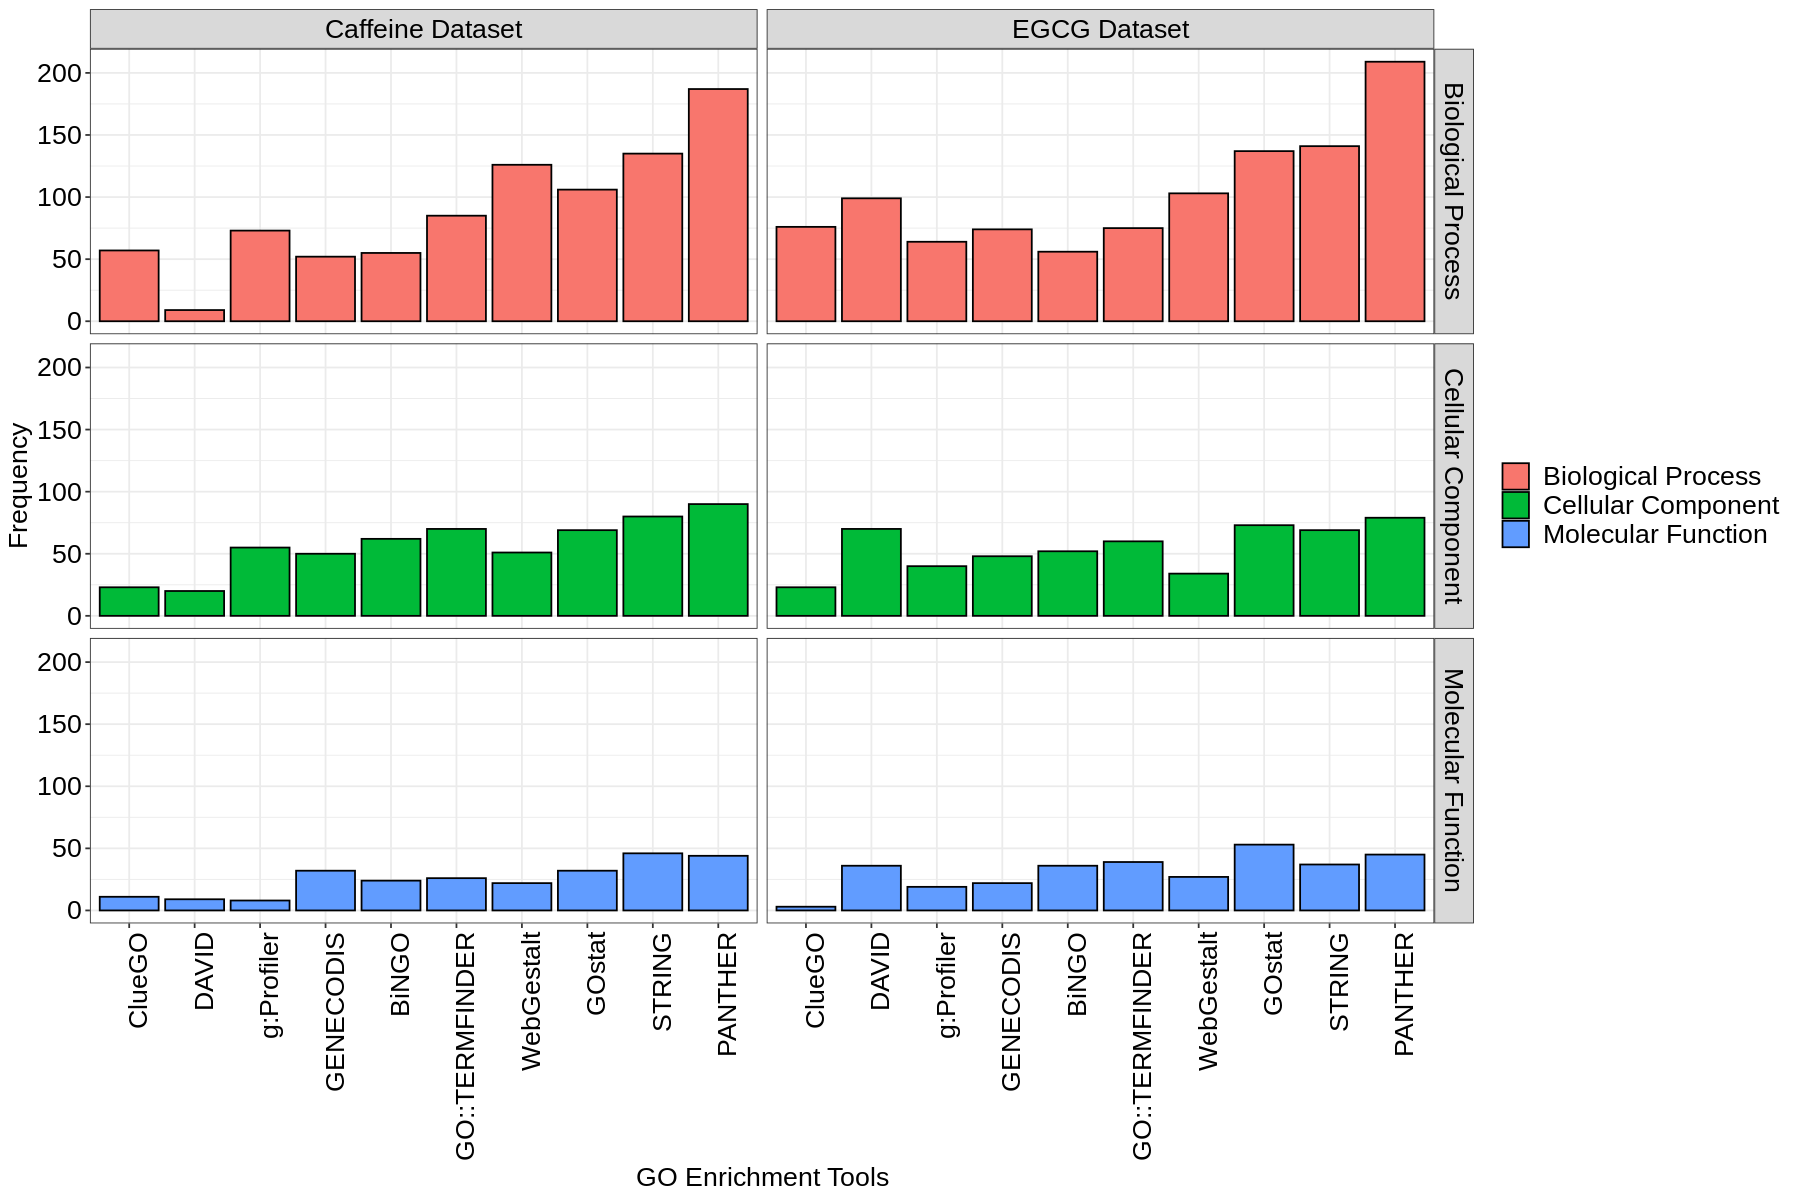

In [391]:
options(repr.plot.width=15, repr.plot.height=10)
 
ggplot(count_02,aes(x=reorder(database,count), y=count,fill=type)) +
  geom_bar(stat="identity", color="black", position=position_dodge()) +
  theme_bw() +
  facet_grid(cols=vars(dataset),rows=vars(type)) +
  labs(fill = "") +
  xlab("GO Enrichment Tools") +
  ylab("Frequency") +
  scale_fill_discrete(name = "", labels = c("Biological Process",
                                                "Cellular Component",
                                                "Molecular Function")) +
                                                font_custom

In [433]:
BP_mean <- cor_cat_02 %>% filter(Type == "Biological Process")
mean(BP_mean$`EGCG Dataset`)
mean(BP_mean$`Caffeine Dataset`)

[1] 103.4

[1] 88.5

New names:
* database -> database...1
* dataset -> dataset...2
* type -> type...3
* count -> count...4
* database -> database...5
* ...



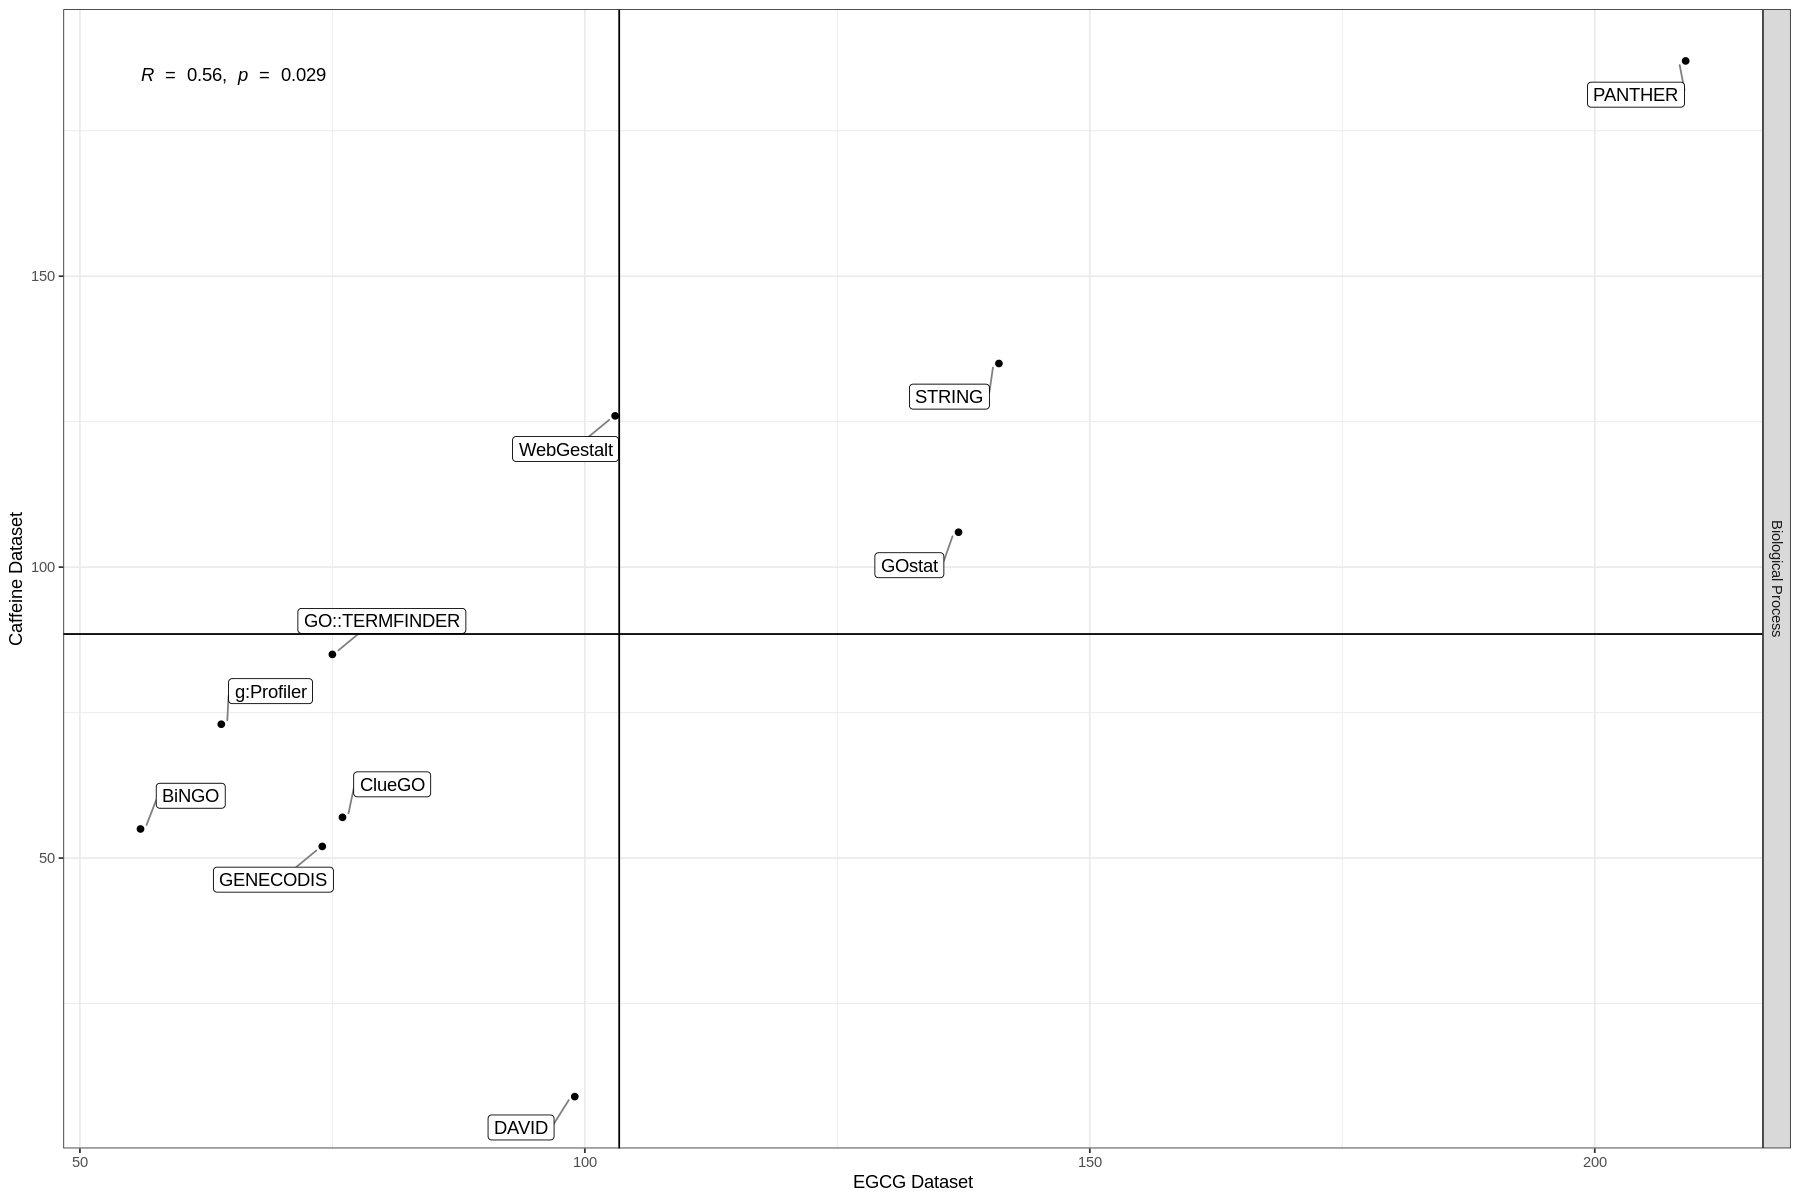

In [441]:
options(repr.plot.width=15, repr.plot.height=10)
count_02_egcg <- count_02 %>% filter(dataset == "EGCG Dataset")
count_02_caf <- count_02 %>% filter(dataset == "Caffeine Dataset")
cor_cat <- bind_cols(count_02_egcg,count_02_caf)
cor_cat_02 <- cor_cat[,-c(2,5:7)]
names(cor_cat_02) <- c("GO Enrichment Database","Type","EGCG Dataset","Caffeine Dataset")


plot_scatter <- function(i){
  BP_me <- cor_cat_02 %>% filter(Type == i)
  cor_cat_02 %>% filter(Type == i) %>%
  ggplot( aes(x= `EGCG Dataset`, y= `Caffeine Dataset`))+
  geom_label_repel(aes(label = `GO Enrichment Database`),
                   box.padding   = 0.35, 
                   point.padding = 0.5,
                   segment.color = 'grey50') +
  geom_point() +
  theme_bw() +
  facet_grid(rows=vars(Type)) +
  stat_cor(method="kendall") + geom_vline(xintercept=mean(BP_me$`EGCG Dataset`)) + geom_hline(yintercept=mean(BP_me$`Caffeine Dataset`))
}

plot_scatter("Biological Process")

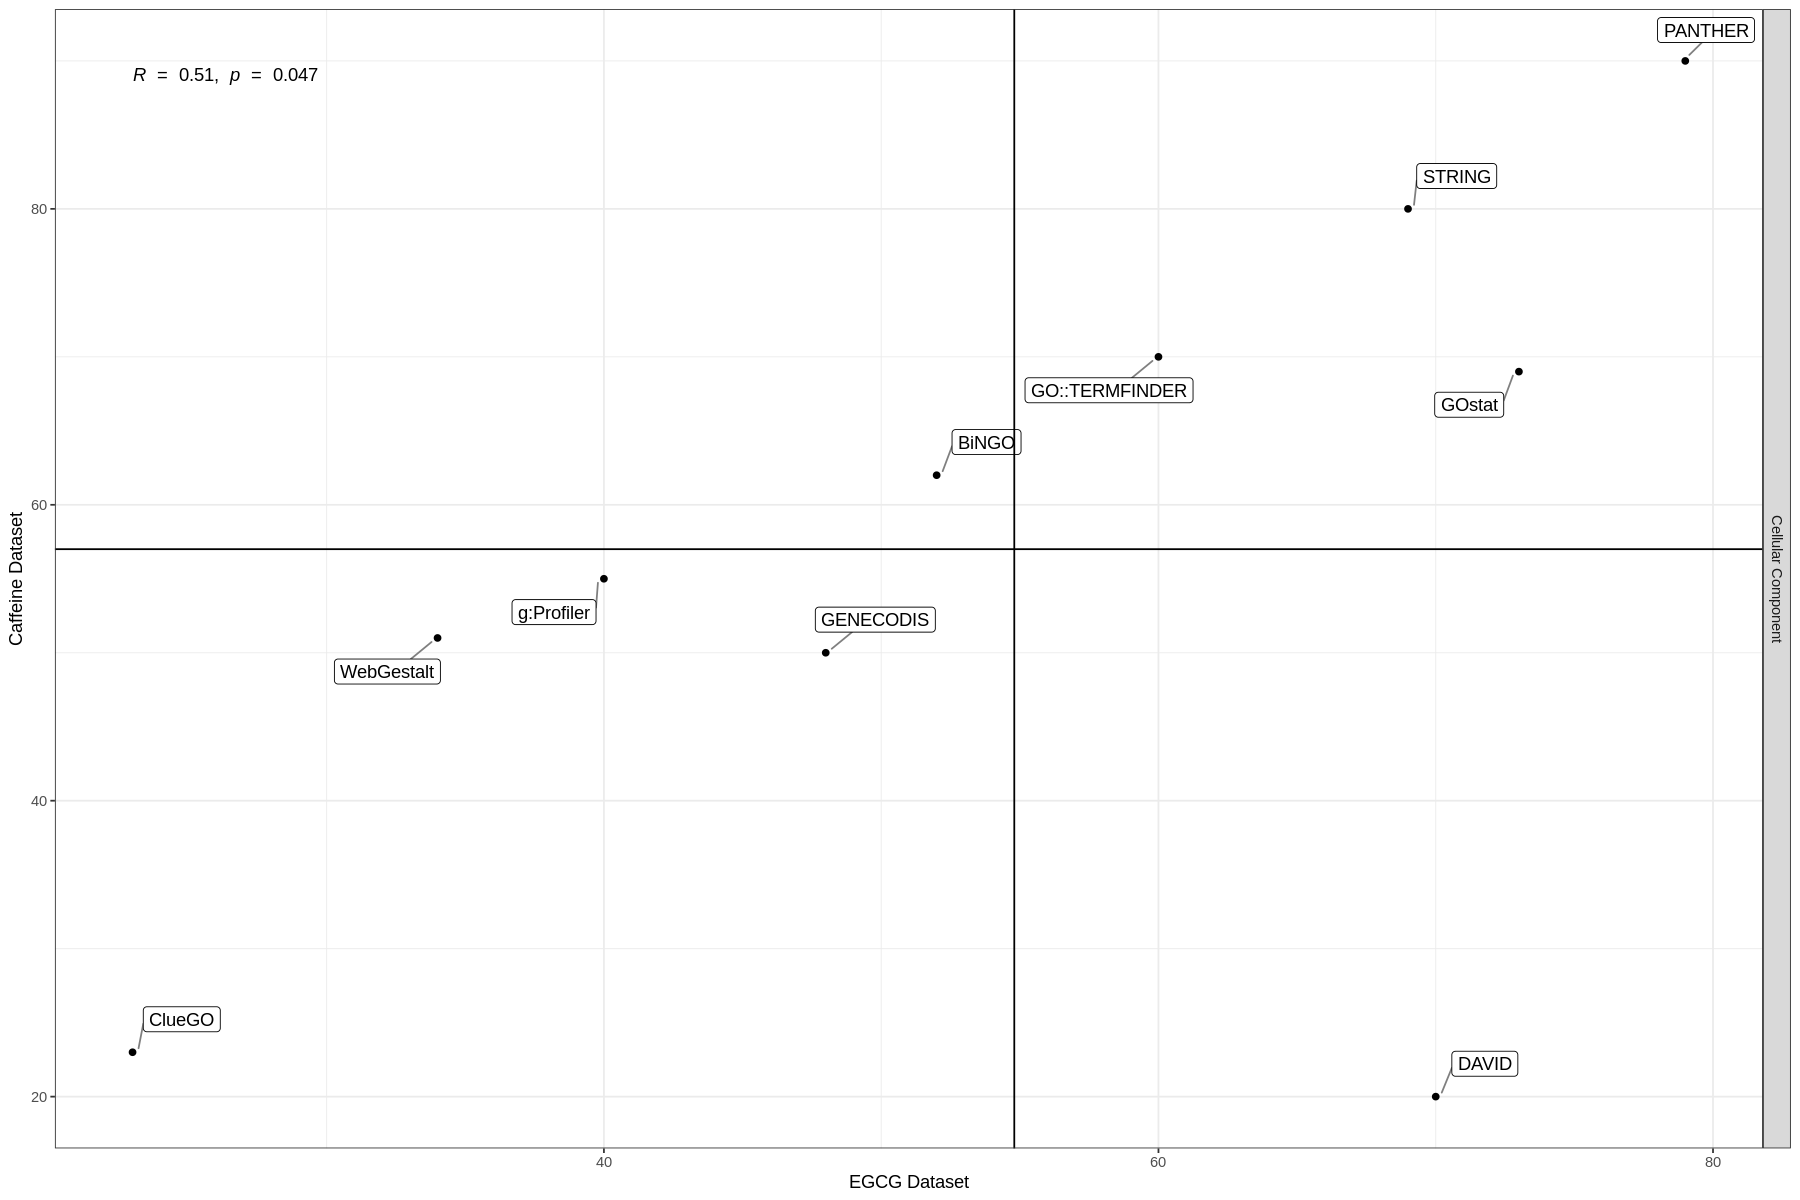

In [442]:
plot_scatter("Cellular Component")


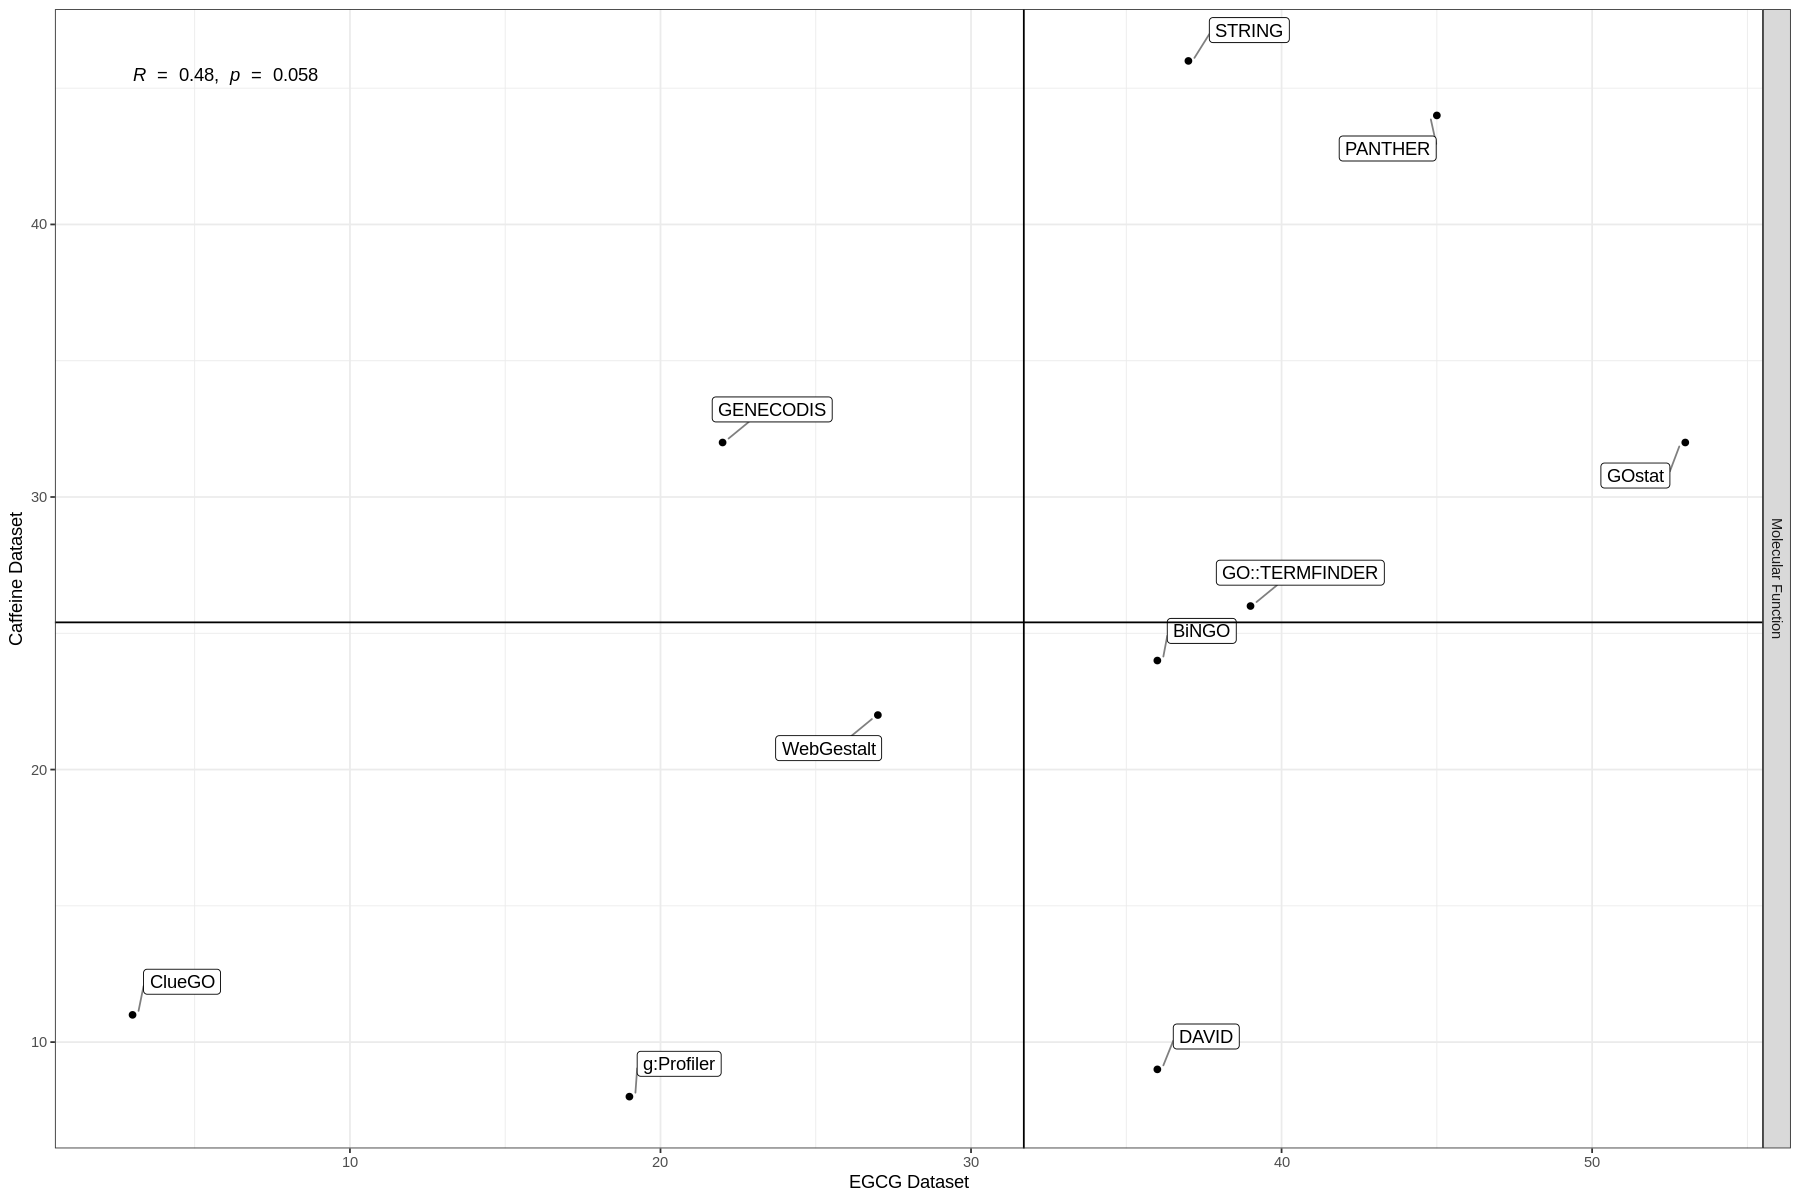

In [443]:
plot_scatter("Molecular Function")

In [79]:
df.02 <- df_01[with(df_01, order(database,dataset)), ] %>% select(-gene) %>% unique() %>% group_by(database,dataset,ref,type) %>% 
  dplyr::summarise(CNT=n()) %>% as.data.frame() 
colnames(df.02)

`summarise()` regrouping output by 'database', 'dataset', 'ref' (override with `.groups` argument)



[1] "database" "dataset"  "ref"      "type"     "CNT"

`summarise()` regrouping output by 'database', 'dataset', 'ref' (override with `.groups` argument)

`geom_smooth()` using formula 'y ~ x'



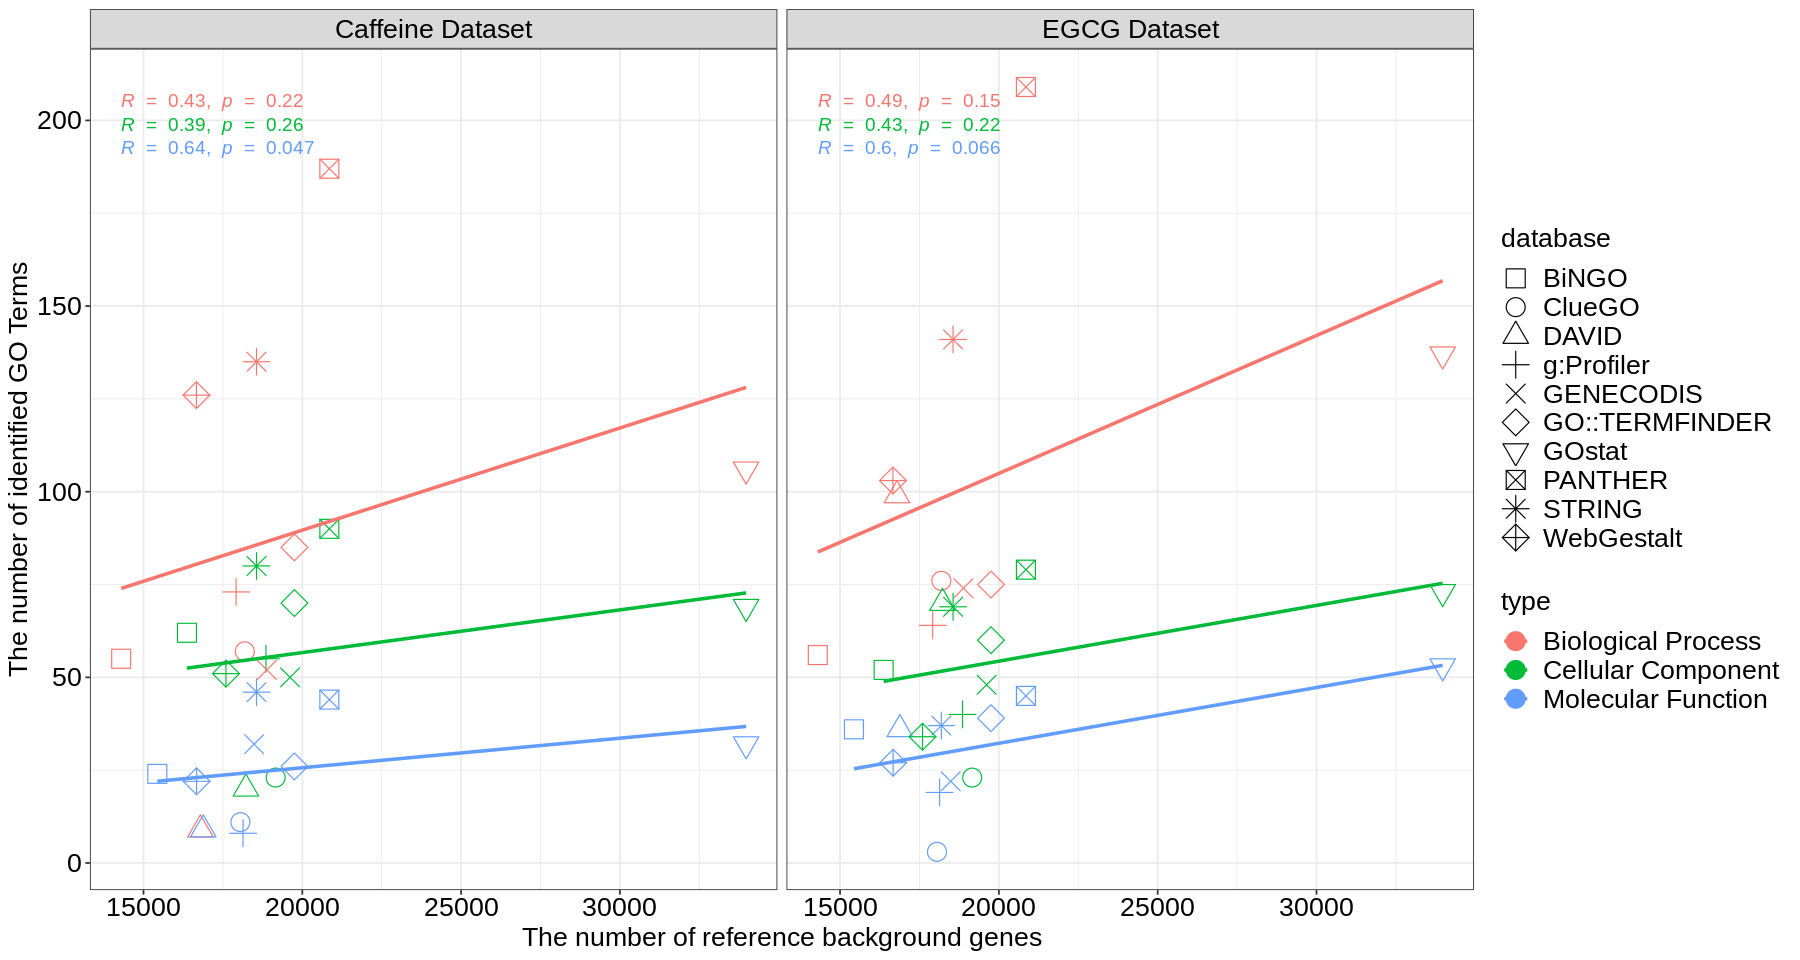

In [87]:
df.02 <- df_01[with(df_01, order(database,dataset)), ] %>% select(-gene) %>% unique() %>% group_by(database,dataset,ref,type) %>% 
  dplyr::summarise(CNT=n()) %>% as.data.frame() 

options(repr.plot.width=15, repr.plot.height=8)
ggplot(df.02,aes(ref,CNT,color=type)) +
  geom_point(aes(shape=database),size=5) + 
  scale_shape_manual(values=seq(0,10)) +
  facet_grid(cols=vars(dataset))  +
  theme_bw() +
 stat_cor(method="spearman",size = 4) +
  xlab("The number of reference background genes") +
  ylab("The number of identified GO Terms")+ font_custom.02+ 
  geom_smooth(method='lm', se = FALSE)


## GO proportion

In [ ]:
chi <- df_01[,-1] %>% unique() %>% dplyr::select(database,type,dataset)  
chi_02 <- table(chi$database,chi$type,chi$dataset) %>% as.data.frame()
chi_03 <- reshape(chi_02, idvar = c("Var1","Var3"), timevar = "Var2", direction = "wide") 
names(chi_03) <- c("database","dataset","BP","CC","MF")
chi_4 <- cbind(chi_03[,c(1,2)], prop.table(as.matrix(chi_03[,-c(1,2)]), margin = 1)) %>% melt(.)
head(chi_4)

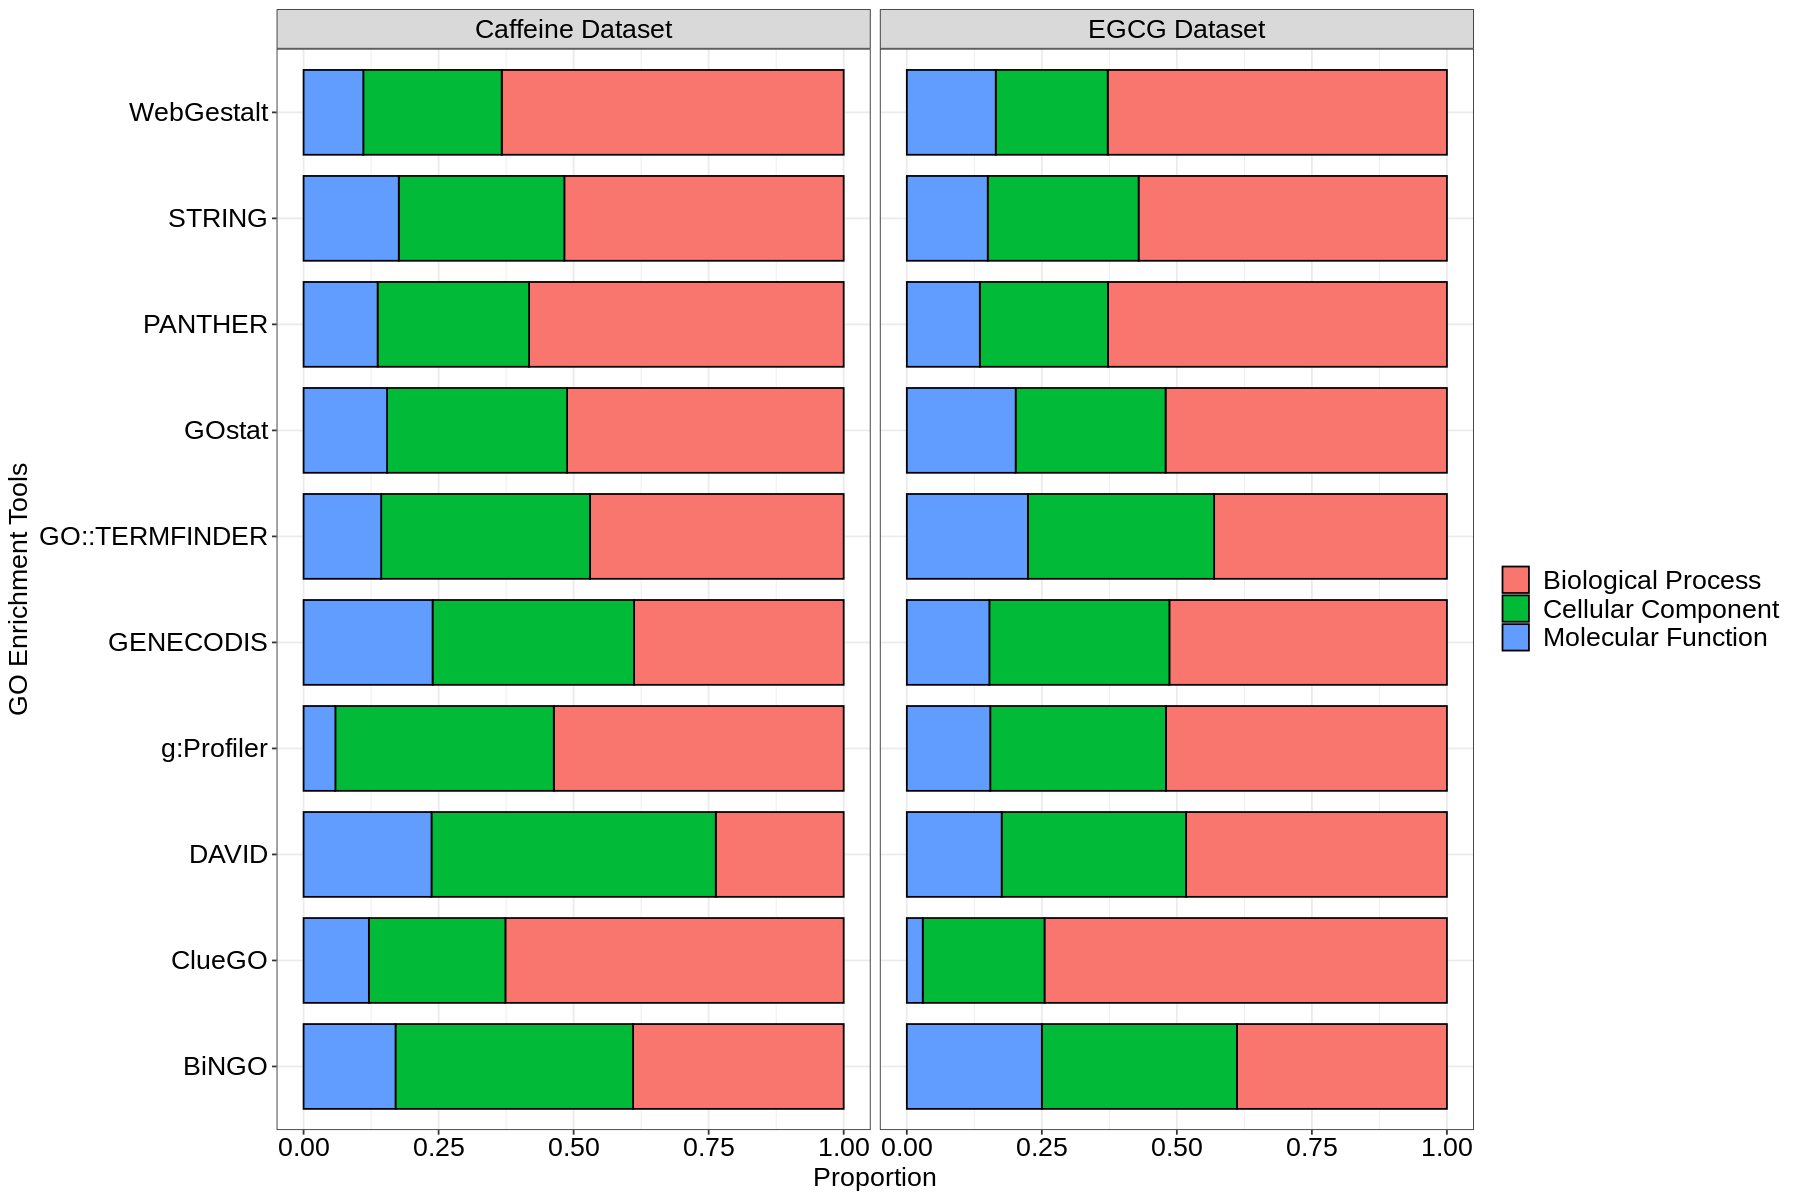

In [91]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(data=chi_4, aes(x=reorder(database,-value), y=value, fill=variable)) +
  geom_bar(stat="identity",color = "black",width=0.8) +
  theme_bw() + ylab("Proportion") + xlab("GO Enrichment Tools")  + guides(fill=guide_legend(title="")) + 
  coord_flip()+
  facet_grid(. ~ dataset)  +
  scale_fill_discrete(name = "", labels = c("Biological Process",
                                            "Cellular Component",
                                            "Molecular Function")) +
                                            font_custom.02

## Chi-square Test

### Test between group

In [108]:
# Chitest between
chi_between <- list()
for (i in unique(chi_03$database) %>% unlist()) {
  chi_05 <- chi_03 %>% filter(.,database == i) %>% dplyr::select(-dataset)
  chi_06 <- chi_05[,-c(1)]
  x <- chisq.test(chi_06)$p.value
  chi_between[i] <- x
  chi_between.02 <- p.adjust(chi_between, method = "fdr")
}
chi_between.02 %>% as.data.frame()

,.
,<dbl>
BiNGO,0.3273694
ClueGO,0.1180953
DAVID,0.1180953
g:Profiler,0.1180953
GENECODIS,0.1696015
GO::TERMFINDER,0.2906301
GOstat,0.3371899
PANTHER,0.4644606
STRING,0.4644606


### Within-Dataset 

In [94]:
# Chitest within
for (i in unique(chi_03$dataset) %>% unlist()) {
  print(i)
  chi_05 <- chi_03 %>% filter(.,dataset == i) %>% dplyr::select(-database)
  chi_06 <- chi_05[,-c(1)]
  x <- chisq.test(chi_06)  
  print(x$statistic)
  print(x$p.value)}



[1] "Caffeine Dataset"
X-squared 
 68.40643 
[1] 8.391832e-08
[1] "EGCG Dataset"
X-squared 
 68.89196 
[1] 6.95257e-08


#### Heatmap For Pairwise Comparison

##### EGCG dataset

In [113]:
x.01 <- chi_03 %>% filter(.,dataset != "Caffeine Dataset") %>% dplyr::select(-dataset)
x.02 <- t(x.01[,-1]) %>% as.data.frame
df_name <- x.01[1] %>% unlist()
names(x.02) <- df_name
x.02

,BiNGO,ClueGO,DAVID,g:Profiler,GENECODIS,GO::TERMFINDER,GOstat,PANTHER,STRING,WebGestalt
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
BP,56,76,99,64,74,75,137,209,141,103
CC,52,23,70,40,48,60,73,79,69,34
MF,36,3,36,19,22,39,53,45,37,27


In [114]:
# initialization
out_list <- list()
column <- 1
# cycle for storing kappa2's output structure
for (i in 1:(ncol(x.02)-1)){
  for (j in (i+1):ncol(x.02)){
    x <- chisq.test(x.02[,c(i,j)])
    out_list[[column]] <- x$p.value
    # renaming the elements
    names(out_list)[column] <- paste0(colnames(x.02[i]), "_", colnames(x.02[j]))
    column <- column + 1
  }
}

res.eg <- do.call(rbind,out_list) %>% as.data.frame()
res.eg$data <- rownames(res.eg)
res.eg.1 <- splitstackshape::cSplit(res.eg, "data", "_")
res.eg.1$type <- "EGCG Dataset"

p.adj <- p.adjust(unlist(res.eg.1[,1]), method = "fdr")
res.eg.1$adj <- as.data.frame(p.adj)
res.eg.1

V1,data_1,data_2,type,adj
<dbl>,<fct>,<fct>,<chr>,<dbl>
1.487834e-08,BiNGO,ClueGO,EGCG Dataset,6.695253e-07
1.322251e-01,BiNGO,DAVID,EGCG Dataset,2.203752e-01
5.678689e-02,BiNGO,g:Profiler,EGCG Dataset,1.111048e-01
4.900617e-02,BiNGO,GENECODIS,EGCG Dataset,1.050132e-01
7.325288e-01,BiNGO,GO::TERMFINDER,EGCG Dataset,7.848522e-01
3.810027e-02,BiNGO,GOstat,EGCG Dataset,9.023749e-02
6.993004e-06,BiNGO,PANTHER,EGCG Dataset,1.048951e-04
1.632792e-03,BiNGO,STRING,EGCG Dataset,6.122969e-03
1.417945e-04,BiNGO,WebGestalt,EGCG Dataset,9.115360e-04



##### Caffeine dataset

In [373]:
x.01 <- chi_03 %>% filter(.,dataset != "EGCG Dataset") %>% dplyr::select(-dataset)
x.02 <- t(x.01[,-1]) %>% as.data.frame
df_name <- x.01[1] %>% unlist()
names(x.02) <- df_name
x.02

,BiNGO,ClueGO,DAVID,g:Profiler,GENECODIS,GO::TERMFINDER,GOstat,PANTHER,STRING,WebGestalt
,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
BP,55,57,9,73,52,85,106,187,135,126
CC,62,23,20,55,50,70,69,90,80,51
MF,24,11,9,8,32,26,32,44,46,22


In [116]:
# initialization
out_list <- list()
column <- 1
# cycle for storing kappa2's output structure
for (i in 1:(ncol(x.02)-1)){
  for (j in (i+1):ncol(x.02)){
    x <- chisq.test(x.02[,c(i,j)])
    out_list[[column]] <- x$p.value
    # renaming the elements
    names(out_list)[column] <- paste0(colnames(x.02[i]), "_", colnames(x.02[j]))
    column <- column + 1
  }
}

res.caf <- do.call(rbind,out_list) %>% as.data.frame()
res.caf$data <- rownames(res.caf)
res.caf.1 <- splitstackshape::cSplit(res.caf, "data", "_")
res.caf.1$type <- "Caffeine Dataset"

p.adj <- p.adjust(unlist(res.caf.1[,1]), method = "fdr")
res.caf.1$adj <- as.data.frame(p.adj)
res.caf.1


Warning message in chisq.test(x.02[, c(i, j)]):
“Chi-squared approximation may be incorrect”
Warning message in chisq.test(x.02[, c(i, j)]):
“Chi-squared approximation may be incorrect”


V1,data_1,data_2,type,adj
<dbl>,<fct>,<fct>,<chr>,<dbl>
1.867590e-03,BiNGO,ClueGO,Caffeine Dataset,0.0076401415
2.042855e-01,BiNGO,DAVID,Caffeine Dataset,0.2553569356
4.375782e-03,BiNGO,g:Profiler,Caffeine Dataset,0.0140650124
3.109859e-01,BiNGO,GENECODIS,Caffeine Dataset,0.3588298967
3.576848e-01,BiNGO,GO::TERMFINDER,Caffeine Dataset,0.4023954177
6.900068e-02,BiNGO,GOstat,Caffeine Dataset,0.1035010244
4.952626e-04,BiNGO,PANTHER,Caffeine Dataset,0.0024763131
2.075584e-02,BiNGO,STRING,Caffeine Dataset,0.0479399967
5.308125e-05,BiNGO,WebGestalt,Caffeine Dataset,0.0007962188


In [117]:
res.all <- rbind(res.caf.1,res.eg.1)
res.all$data_2 <- gsub(".[0-9]", "", res.all$data_2)

res.all$sig <- ifelse(res.all$adj < 0.001,"***",
                      ifelse(res.all$adj < 0.01,"**",
                             ifelse(res.all$adj < 0.05,"*","ns")))

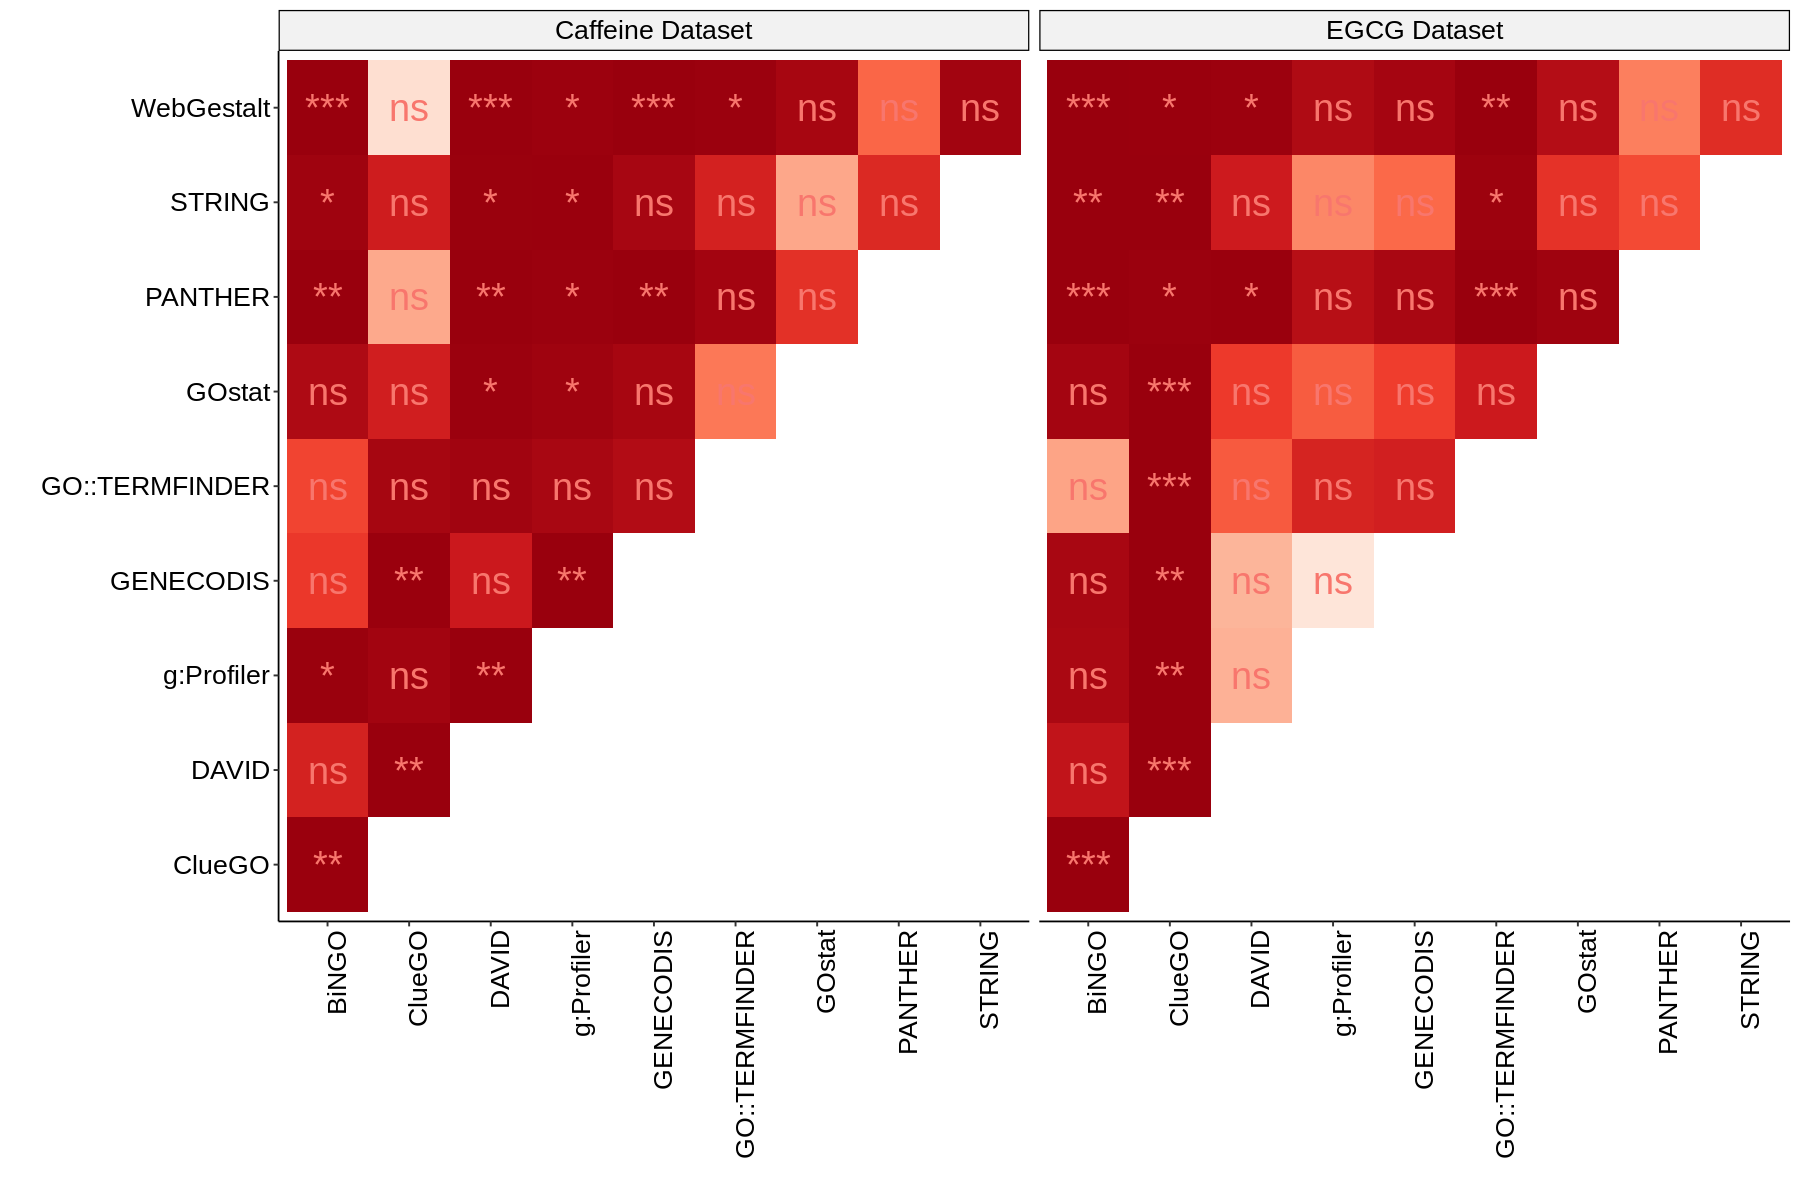

In [118]:
options(repr.plot.width=15, repr.plot.height=10)
ggplot(data = res.all, aes(x = data_1, y = data_2)) +
  geom_tile(aes(fill=V1))+
  facet_grid(cols=vars(type)) + 
  theme_pubr() +
  geom_text(aes(label=sig,color="white"),cex=8)+
  theme(legend.position="none") +
  scale_fill_distiller(palette = "Reds") +
  xlab("") +
  ylab("") + font_custom

# **The comparison of the number of annotated gene**

`summarise()` regrouping output by 'dataset', 'database' (override with `.groups` argument)



[1] "dataset"  "database" "type"     "CNT"      "con"      "dates"

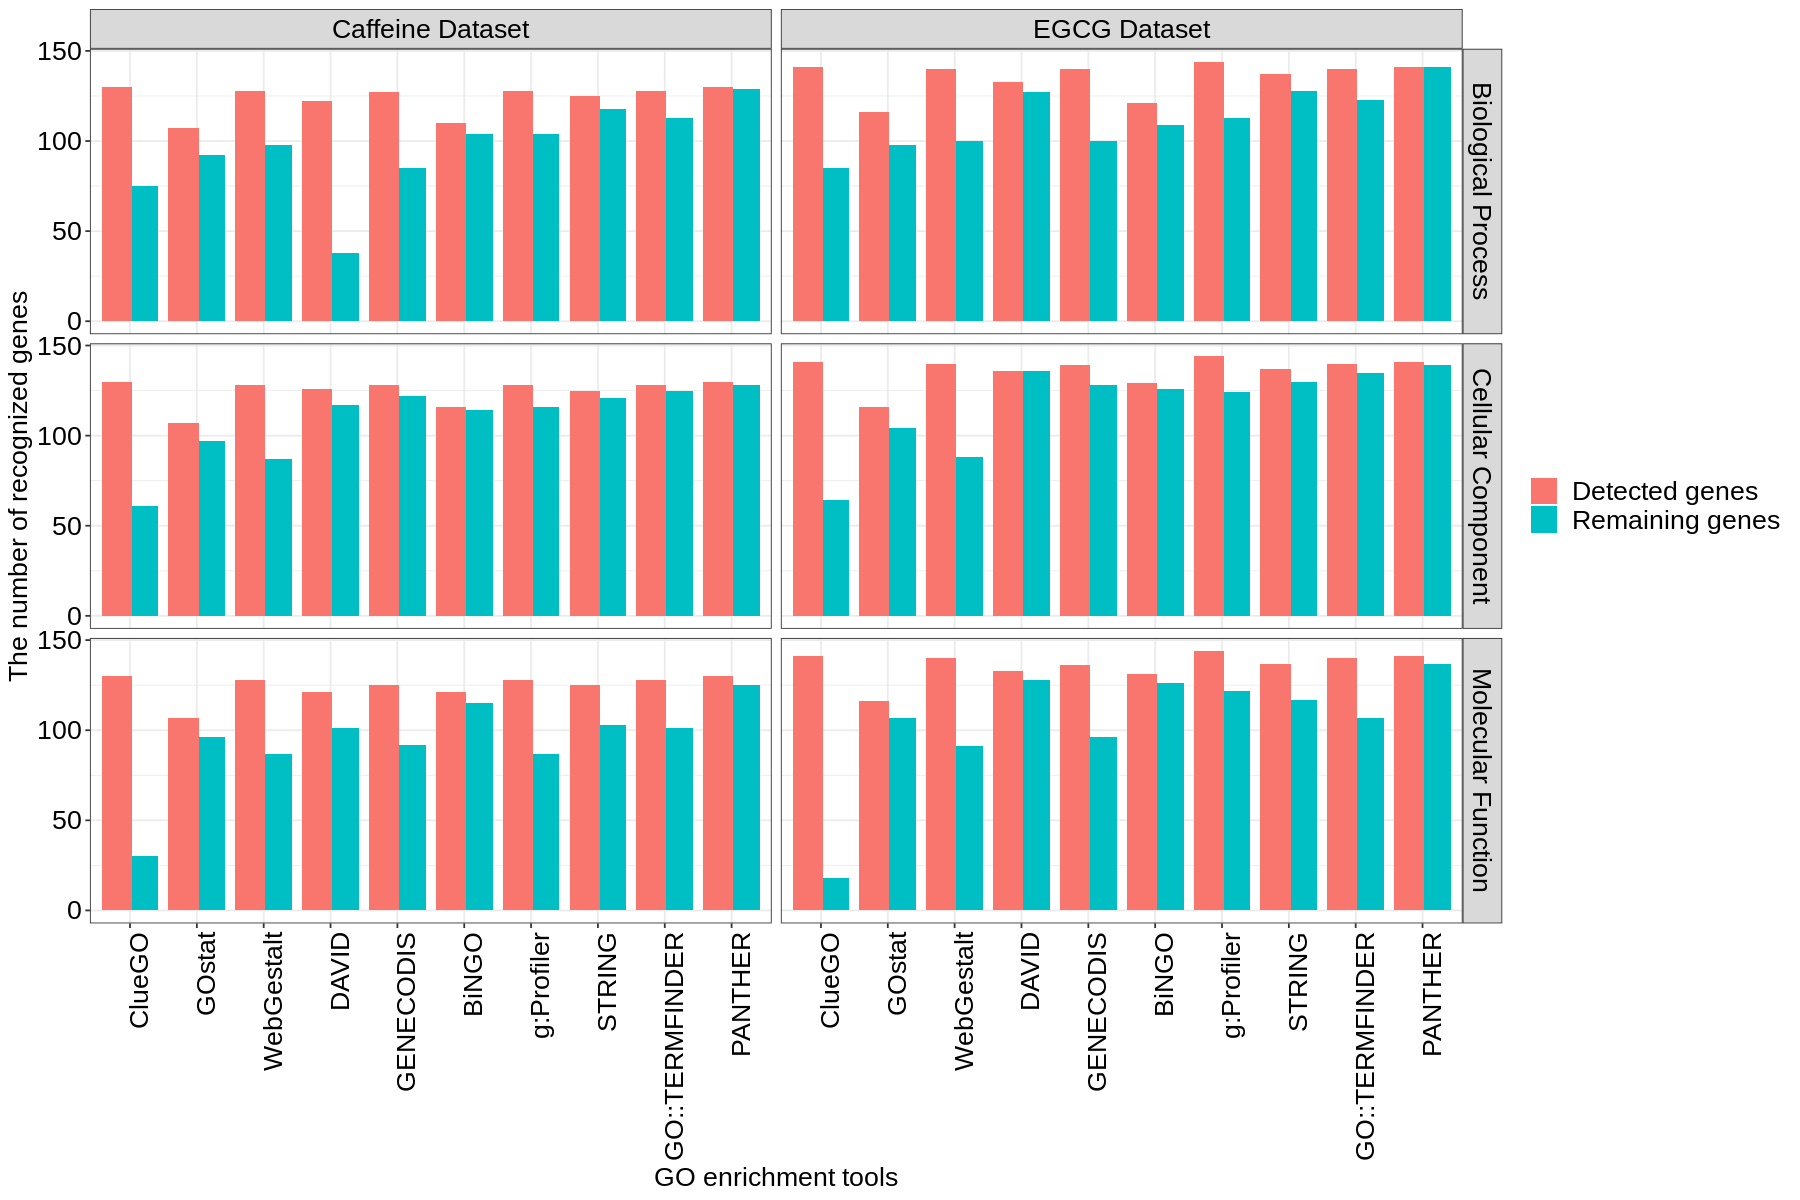

In [285]:
options(repr.plot.width=15, repr.plot.height=10)
df_j <- df_01 %>% select(gene,dataset,database,type) %>% unique() %>% group_by(dataset,database,type) %>% summarise(CNT=n()) 
df_j$con <- "Remaining genes"
detected_gene_df <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Correlation-GOterm-Input.txt")
detected_gene_df$con <- "Detected genes"
names(detected_gene_df) <- c("dataset","CNT","type","database","con") 
detected_gene_df.02 <- bind_rows(df_j,detected_gene_df) 


df_date <- df_01 %>% select(database) %>% unique
dates <- c("03/26/20", "08/01/10","03/26/20","03/26/20",
            "02/06/18","03/26/20","02/17/20","01/14/19",
            "01/10/16","01/06/20")
betterDates <- as.Date(dates,format = "%m/%d/%y")
df_date$dates <- betterDates
cdf <- inner_join(detected_gene_df.02,df_date,by="database")
colnames(cdf)
ggplot(cdf,aes(reorder(database,CNT),CNT,fill=con))+ 
  geom_bar(stat="identity", position = position_dodge(width = 0.8)) + 
  theme_bw()+ 
  font_custom +
  ylab("The number of recognized genes") +
  xlab("GO enrichment tools") +
  labs(fill="") +
  facet_grid(rows=vars(type),cols=vars(dataset))

`summarise()` regrouping output by 'id', 'database', 'dataset' (override with `.groups` argument)

`summarise()` regrouping output by 'id', 'database', 'dataset' (override with `.groups` argument)



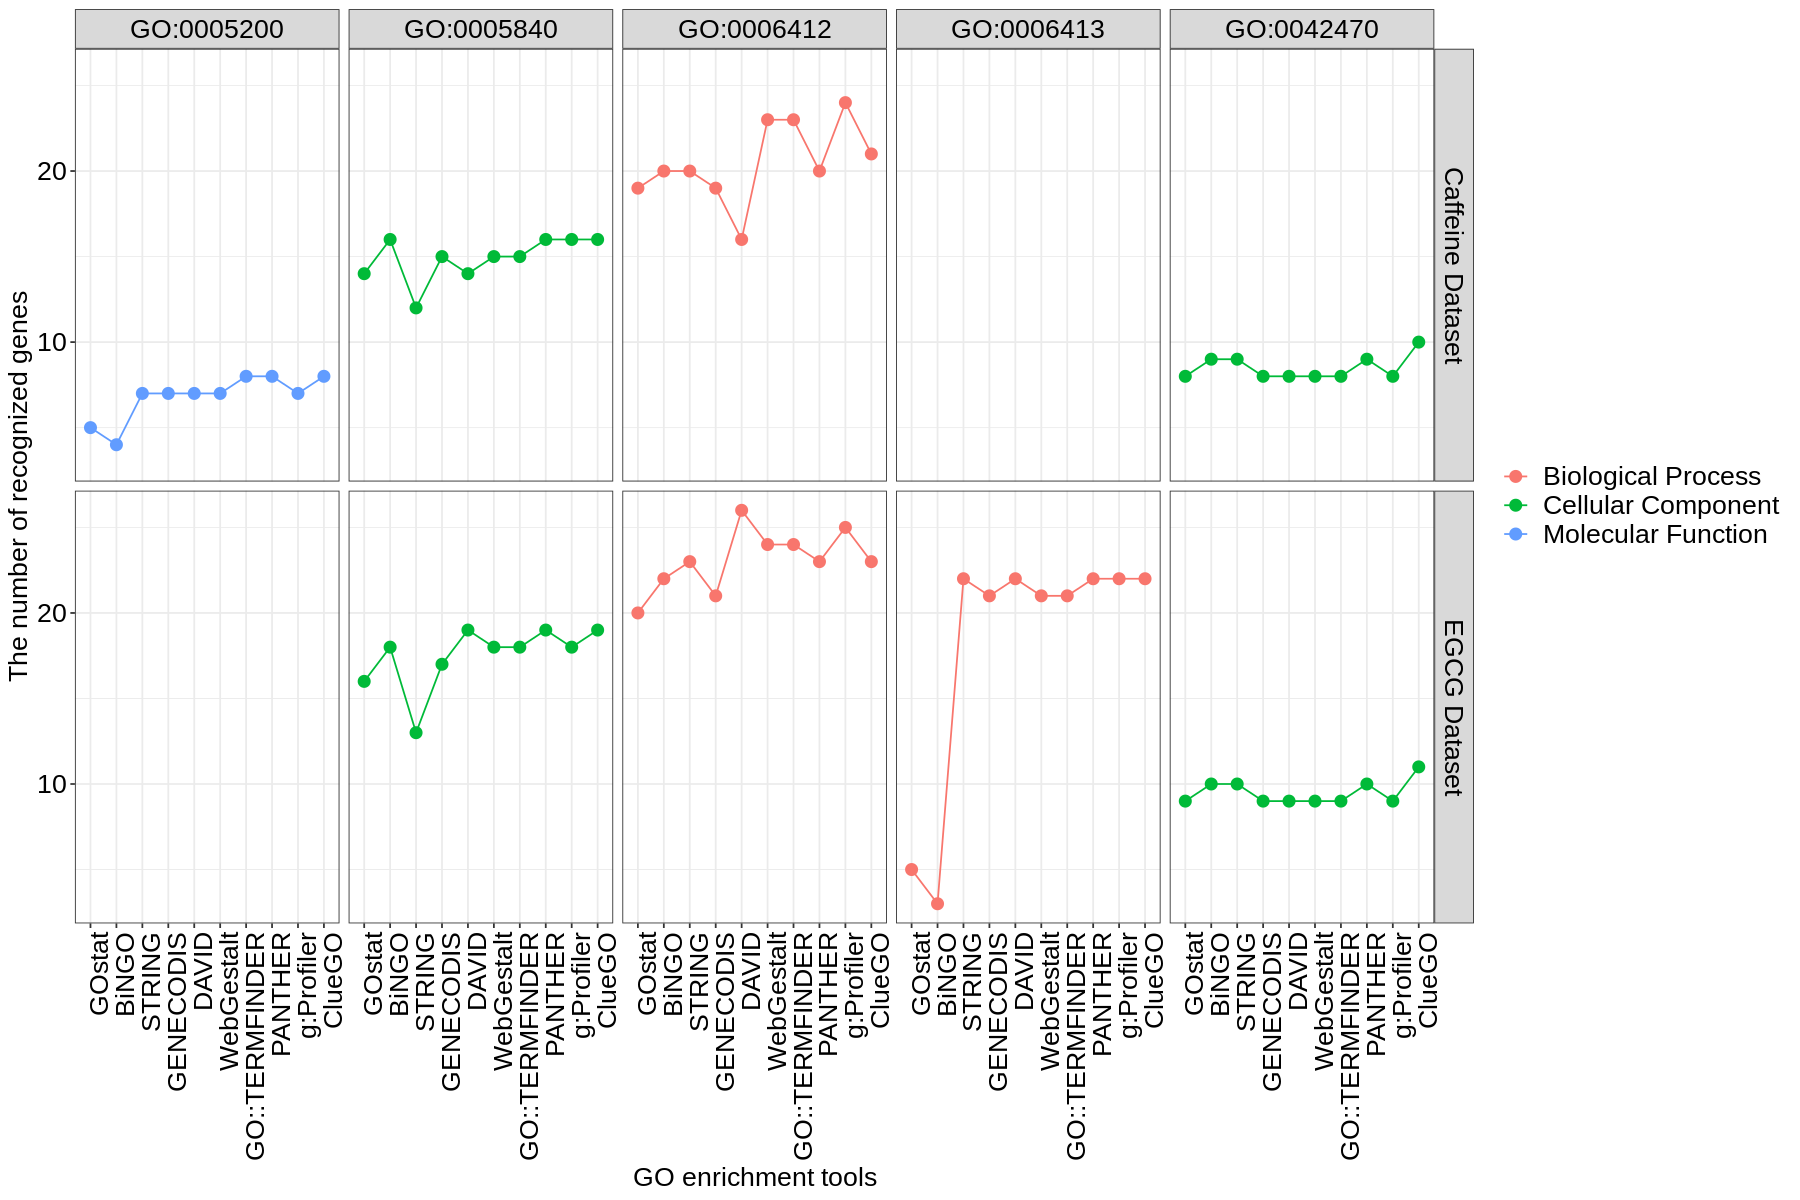

In [237]:
count_gene_in_common_GO <- function(i){
  df.01.01 <- df_01 %>% select(id,dataset,database) %>% filter(dataset == i) %>% unique()  
  df.01.02 <- table(df.01.01$id) %>% melt() %>% filter(value==10) %>% select(Var1) %>% unlist()
  df_01_ <- df_01 %>% filter(dataset == i) %>% filter(id %in% df.01.02) %>% group_by(id,database,dataset,type) %>% summarise(CNT=n())
  df_01_$dataset <- i
  return(df_01_)
}
EGCG_Common_gene <- count_gene_in_common_GO("EGCG Dataset")
Caffeine_Common_gene <- count_gene_in_common_GO("Caffeine Dataset")

cdf_common_gene <- rbind(EGCG_Common_gene,Caffeine_Common_gene)
cdf_common_gene %>%
ggplot(aes(reorder(database,CNT),CNT,group=dataset,color=type))+ geom_line() +geom_point(size=3) + theme_bw()+ font_custom +
facet_grid(cols=vars(id),rows=vars(dataset)) +
ylab("The number of recognized genes") +
xlab("GO enrichment tools") +
labs(color="")


# **The comparison of common vs. unique identified GO terms in the current and previous study**







## Plot Intersection

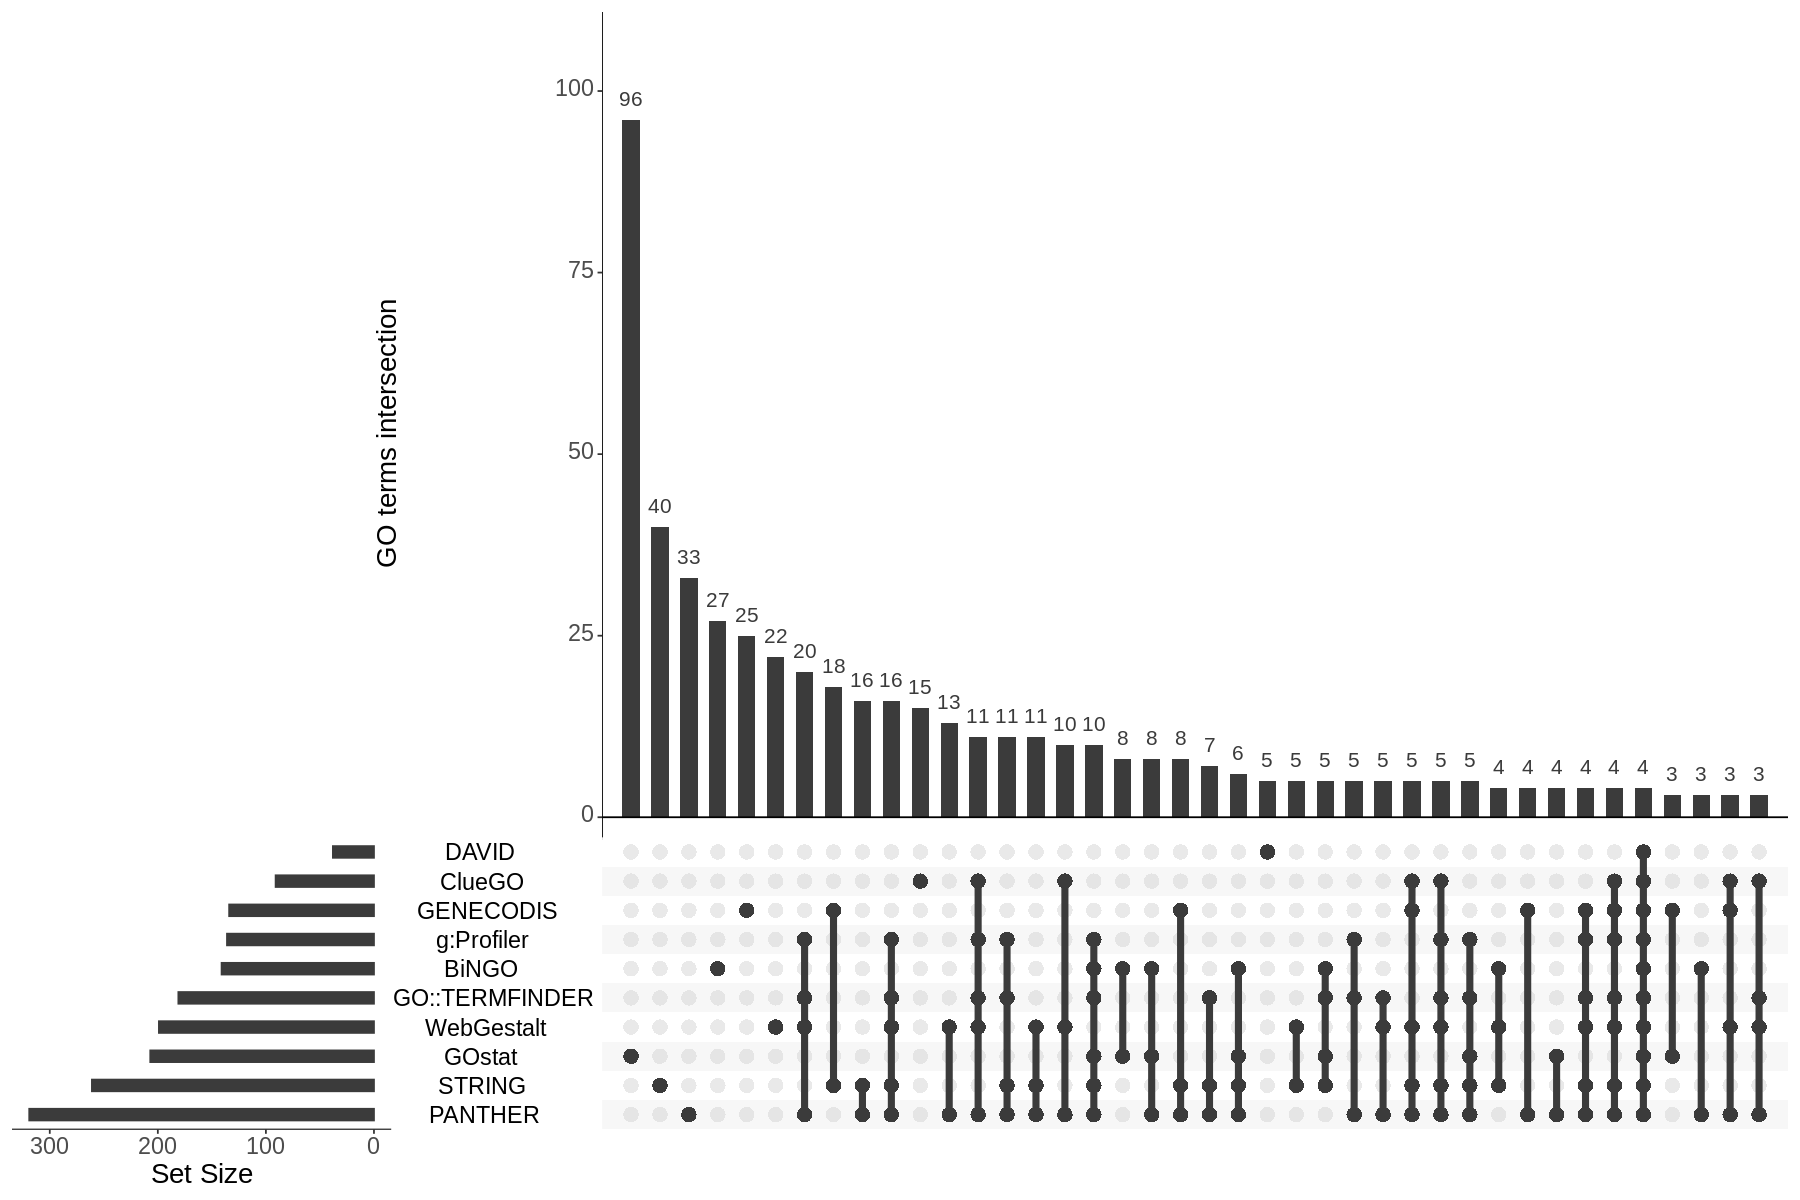

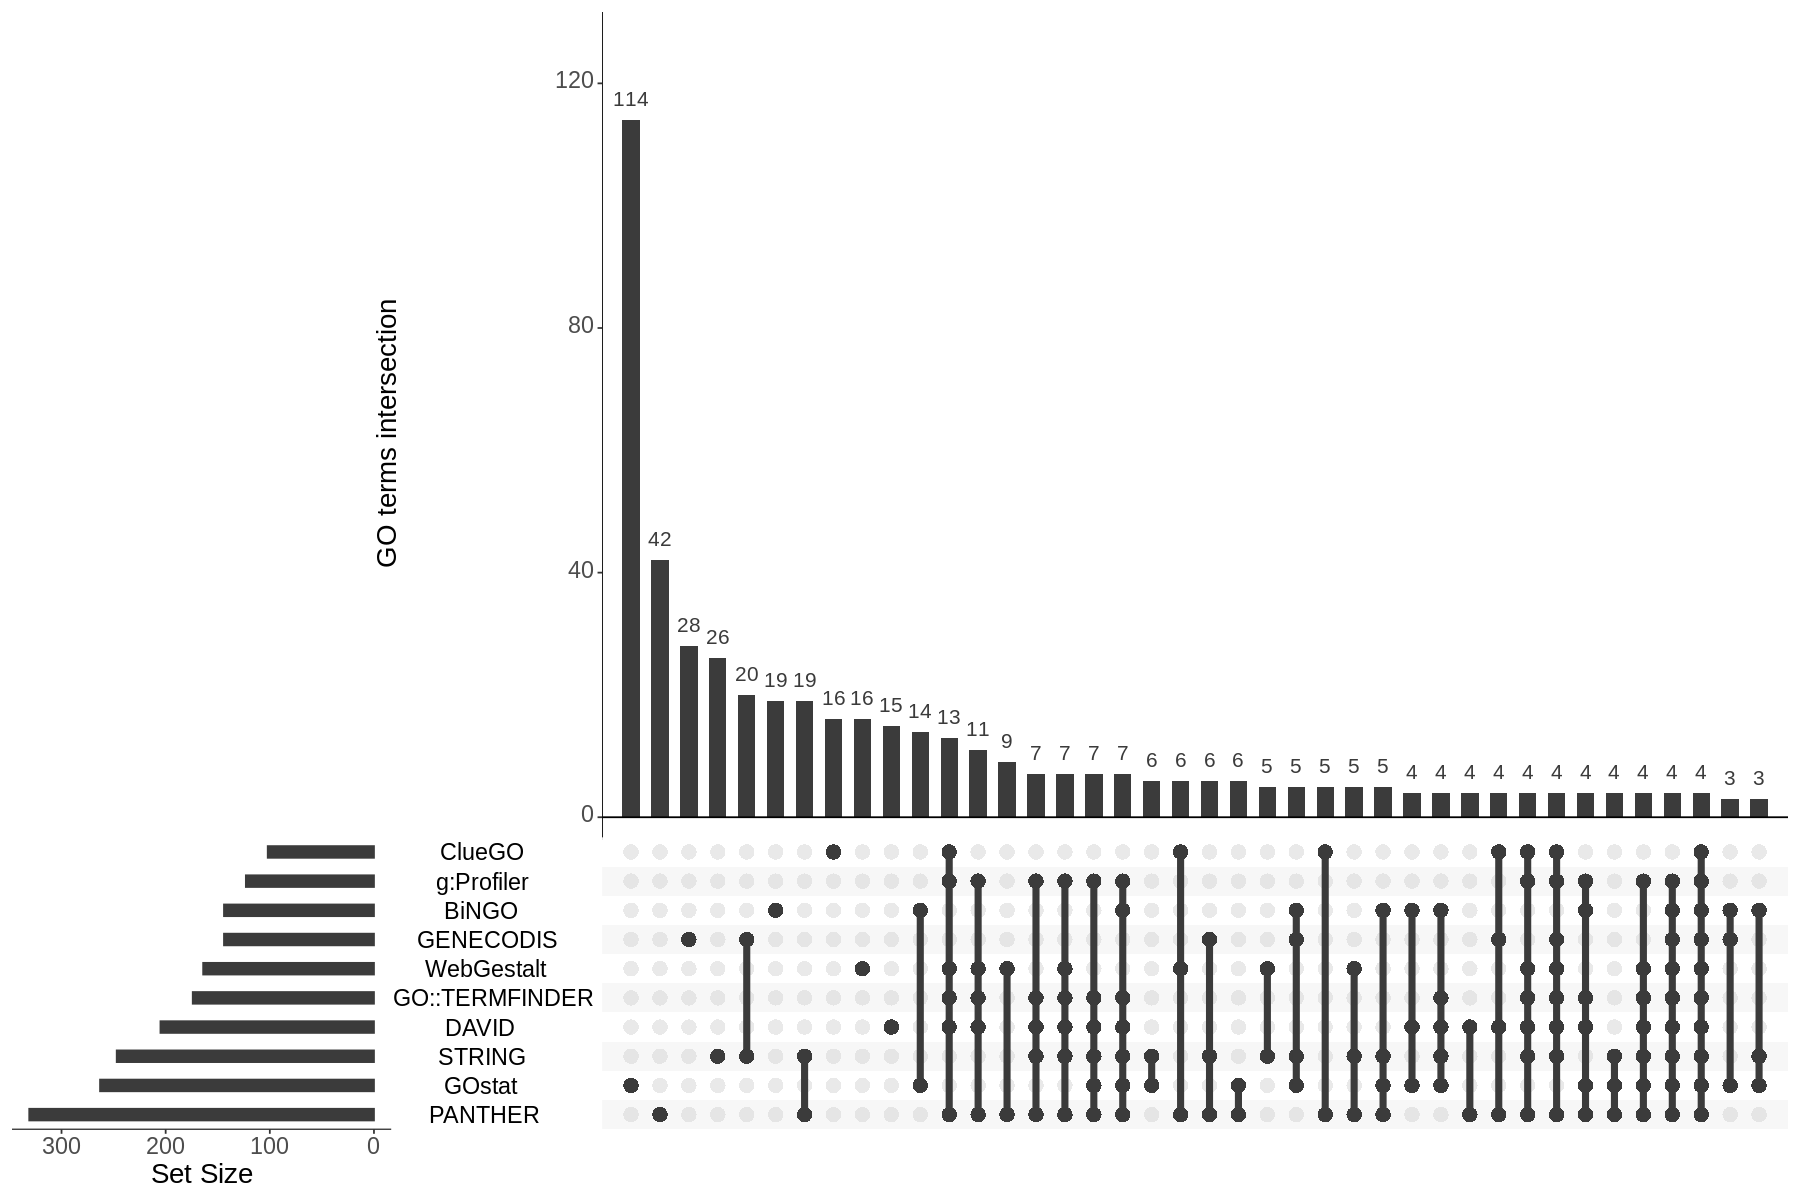

In [324]:
library(UpSetR)
plot_intersection <- function(i){
  pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% 
  dplyr::select(-gene) %>% unique() %>% filter(dataset == i)
  pca_new_02 <- pca_new[,c(1,5,6,7)] %>% table() %>% melt()
  pca_new_03 <- reshape(pca_new_02, idvar = c("id","type","dataset"), timevar = "database", direction = "wide")
  names(pca_new_03) <- c("id","type","dataset","BiNGO","ClueGO","DAVID","g:Profiler","GENECODIS","GO::TERMFINDER","GOstat","PANTHER","STRING","WebGestalt")
  pca_new_04 <- pca_new_03[,-c(1:3)]
  upset(pca_new_04,nsets = 10, point.size = 4, line.size = 2, text.scale = c(2, 2, 2, 2, 2, 2),
  mainbar.y.label = "GO terms intersection", order.by = "freq")
}

plot_intersection("Caffeine Dataset")
plot_intersection("EGCG Dataset")

### Variation Within Dataset

In [ ]:
pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% dplyr::select(-gene) %>% unique()  
pca_new_02 <- table(pca_new$database,pca_new$id,pca_new$dataset,pca_new$type) %>% as.data.frame()
pca_new_03 <- reshape(pca_new_02, idvar = c("Var1","Var3","Var4"), timevar = "Var2", direction = "wide")
pca_new_03

In [326]:
pca_new <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% dplyr::select(-gene) %>% unique()  
pca_new_02 <- table(pca_new$database,pca_new$id,pca_new$dataset,pca_new$type) %>% as.data.frame()
pca_new_03 <- reshape(pca_new_02, idvar = c("Var1","Var3","Var4"), timevar = "Var2", direction = "wide")

Kappa_between <- function(database,categories){
  chi <- pca_new_03 %>% filter(Var3 == database, Var4 == categories) %>% select(-Var3,-Var4) 
  chi.01 <- chi[,-1]
  rownames(chi.01) <- chi[,1]
  chi.01[chi.01 > 1]<-1
  ex <-  chi.01 %>% t() %>% as.data.frame()
  out <- as.data.frame(matrix(0, nrow = 1, ncol = ncol(ex) * (ncol(ex)-1) / 2))
  column <- 1

  # cycle for calculation kappa
for (i in 1:(ncol(ex)-1)){
  for (j in (i+1):ncol(ex)){
    out[1,column] <- irr::kappa2(ex[,c(i,j)])$value
    colnames(out)[column] <- paste(colnames(ex[i]), 
                                      "&", colnames(ex[j]))
    column <- column + 1
  }
}
res <- t(out) %>% as.data.frame() 
res$categories <- categories
res$databases <- database
res
}


In [ ]:
EGCG.BP <- Kappa_between("EGCG Dataset","Biological Process")
EGCG.MF <- Kappa_between("EGCG Dataset","Molecular Function")
EGCG.CC <- Kappa_between("EGCG Dataset","Cellular Component")

Caf.BP <- Kappa_between("Caffeine Dataset","Biological Process")
Caf.MF <- Kappa_between("Caffeine Dataset","Molecular Function")
Caf.CC <- Kappa_between("Caffeine Dataset","Cellular Component")

cdf_EGCG_validate <- rbind(EGCG.BP,EGCG.MF,EGCG.CC)
cdf_caffeine_validate <- rbind(Caf.BP,Caf.MF,Caf.CC)
cdf_validate <- cbind(cdf_EGCG_validate,cdf_caffeine_validate)
cdf_validate.02 <- cdf_validate[,-c(2,3,6)] 
names(cdf_validate.02) <- c("EGCG","Caffeine","Categories")
print(cdf_validate.02)

Using Categories, con_02 as id variables

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



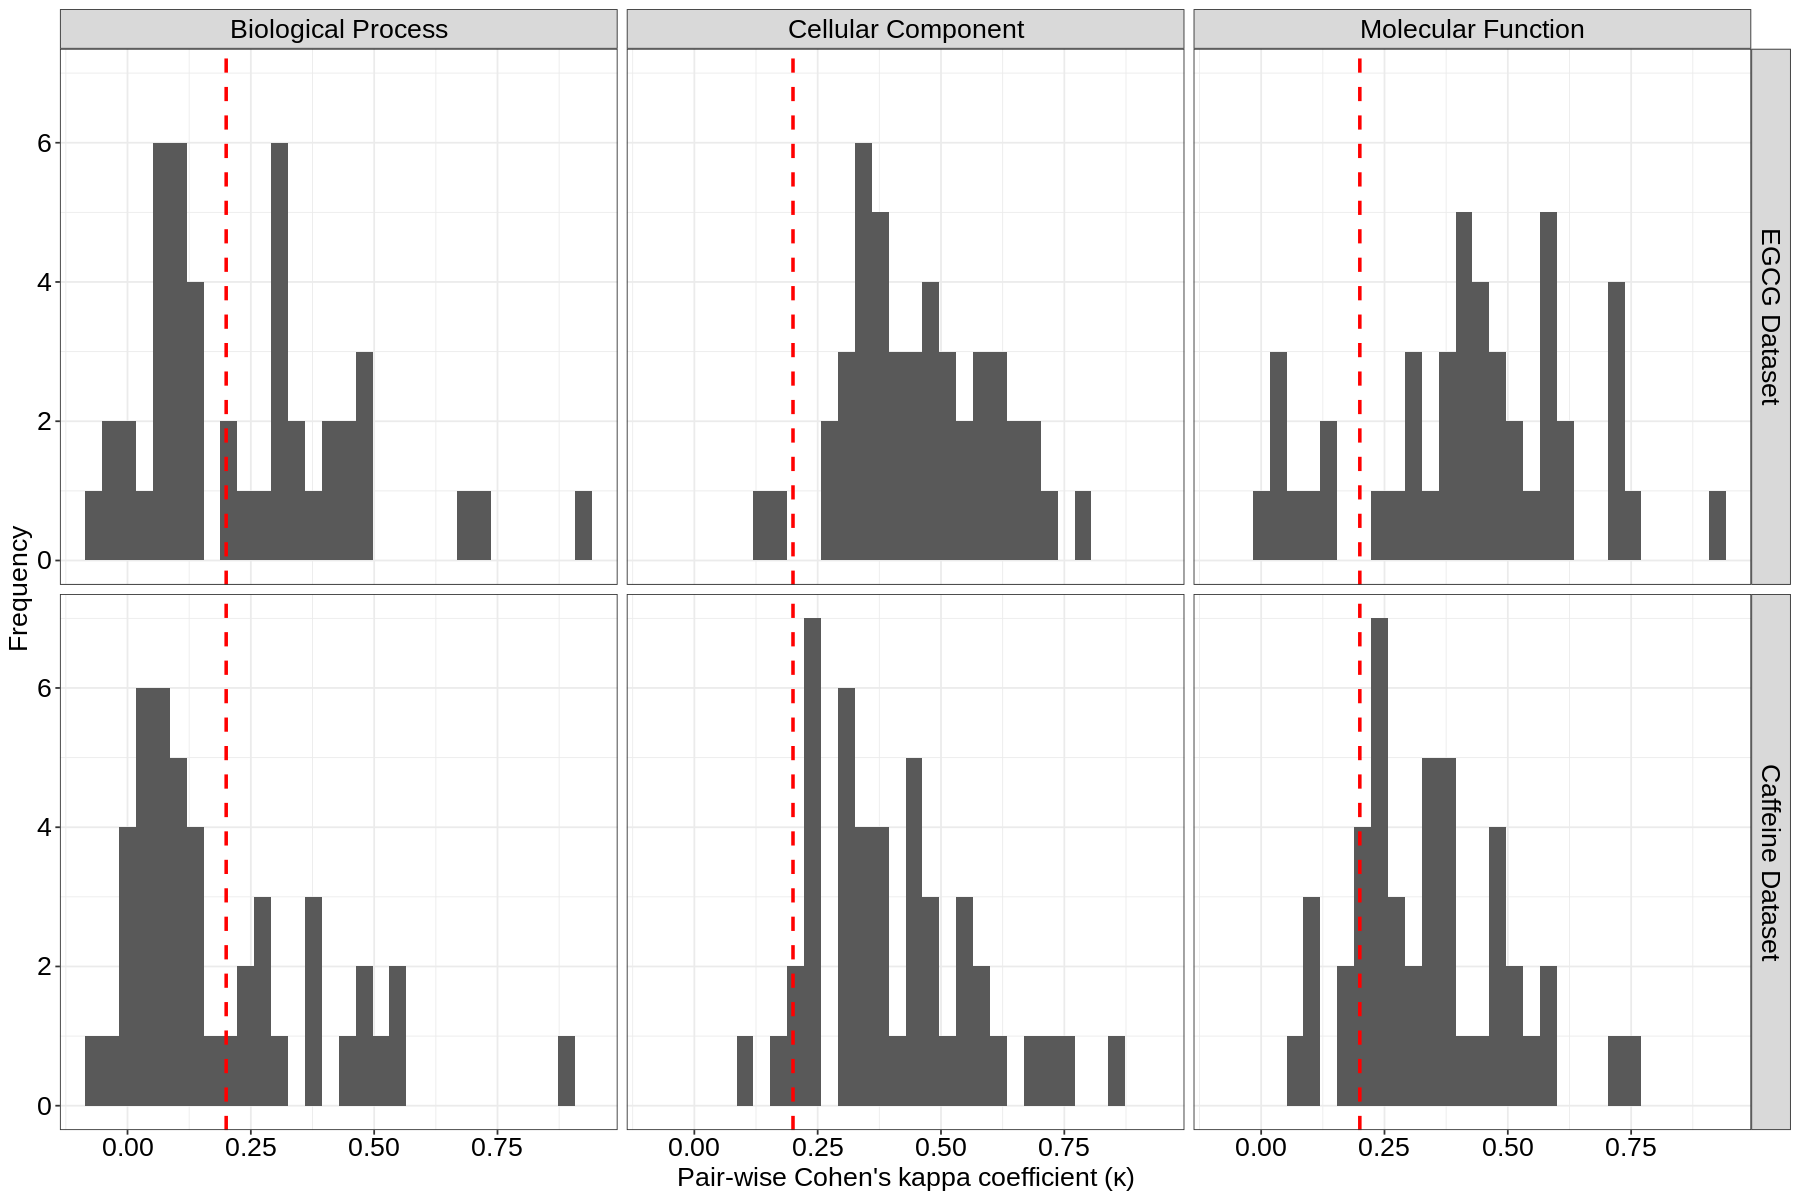

In [332]:
cdf_validate.02$con_02 <- ifelse(cdf_validate.02$Caffeine < 0.2 & cdf_validate.02$EGCG < 0.2,"Difference","Not difference")
names <- c(`Biological Process` = "Biological Process",
           `Cellular Component` = "Cellular Component",
           `Molecular Function`="Molecular Function",
           Caffeine = "Caffeine Dataset",
           EGCG = "EGCG Dataset")

cdf_validate.02%>% melt() %>% 
  ggplot(aes(x=value)) +
  geom_histogram() +
  facet_grid(cols=vars(Categories),rows=vars(variable), labeller = as_labeller(names)) +
  geom_vline(xintercept=0.2, linetype="dashed", color = "red",size=1) +
  theme_bw() +
  xlab("Pair-wise Cohen's kappa coefficient (κ)")+
  ylab("Frequency")+ guides(color = FALSE) +
  font_custom.02

### Variation Between Dataset

##### Kappa Test

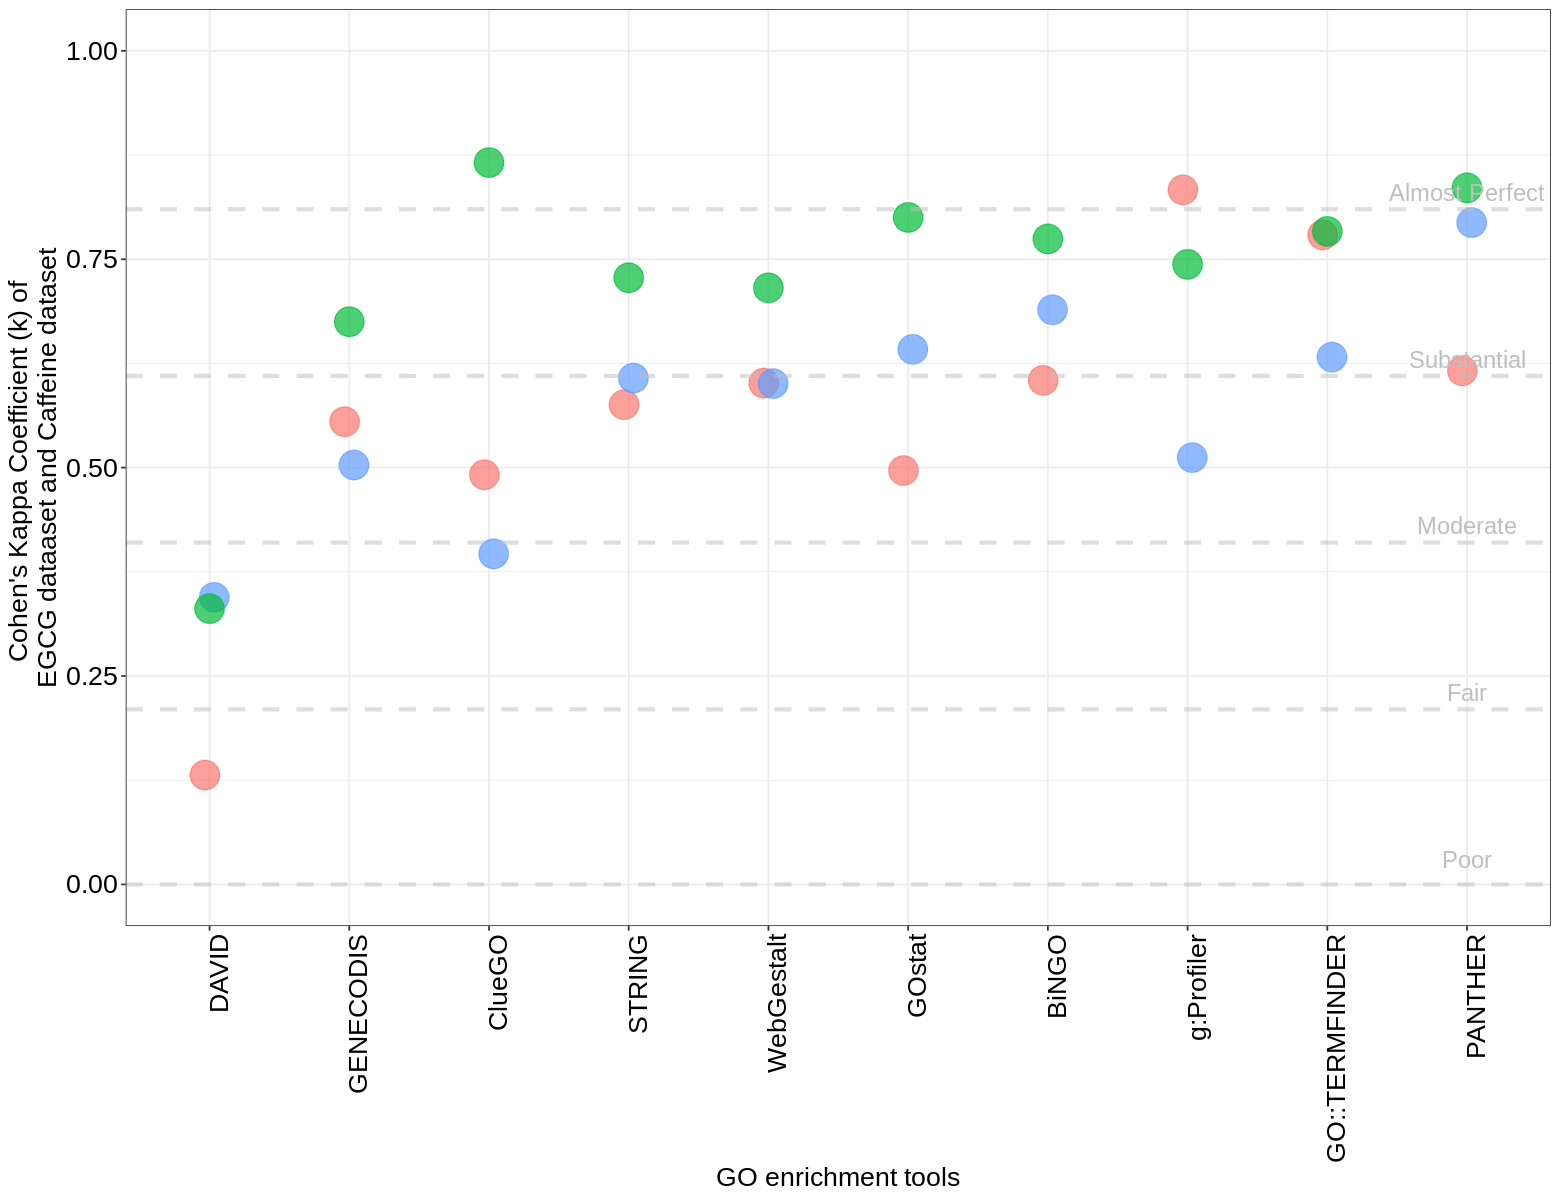

In [338]:
pca.list <- pca_new_03[,1] %>% unique() %>% unlist()
cal_kap <- function(j){
  kap <- list()
  for(i in pca.list){
    chi <- pca_new_03 %>% filter(Var1 == i,Var4 == j) 
    chi.02 <- chi[,-c(1,2,3)] %>% t()
    chi.03 <- irr::kappa2((chi.02))$value %>% as.data.frame()
    chi.03$database <- i
    chi.03$categories <- j
    names(chi.03) <- c("kappa","database","categories")
    kap[[i]] <- chi.03
  } 
  big_data = do.call(rbind, kap)
}

big_data.BP <- cal_kap("Biological Process")
big_data.MF <- cal_kap("Molecular Function")
big_data.CC <- cal_kap("Cellular Component")

all.kap <- rbind(big_data.BP,big_data.MF,big_data.CC)

options(repr.plot.width=13, repr.plot.height=10)
ggplot(data=all.kap, aes(x=reorder(database,kappa), y=kappa,color=categories)) +
  geom_point(aes(color=categories),size = 8,alpha = 0.7, position=position_dodge(width=0.1))+ 
  theme_bw() +
  xlab("GO enrichment tools") +
  ylab("Cohen's Kappa Coefficient (k) of \nEGCG dataaset and Caffeine dataset") +
        font_custom +
        guides(color = FALSE)+
        ylim(0,1) + 
         geom_hline(yintercept=0.00, linetype="dashed", color = "grey",size=1.2,alpha=0.5)+
         geom_hline(yintercept=0.21, linetype="dashed", color = "grey",size=1.2,alpha=0.5)+
         geom_hline(yintercept=0.41, linetype="dashed", color = "grey",size=1.2,alpha=0.5)+
         geom_hline(yintercept=0.61, linetype="dashed", color = "grey",size=1.2,alpha=0.5)+
         geom_hline(yintercept=0.81, linetype="dashed", color = "grey",size=1.2,alpha=0.5)+
         annotate(geom="text", x="PANTHER", y=0.03, label="Poor",color="grey",size=5)+ 
         annotate(geom="text", x="PANTHER", y=0.23, label="Fair",color="grey",size=5)+ 
         annotate(geom="text", x="PANTHER", y=0.43, label="Moderate",color="grey",size=5)+ 
         annotate(geom="text", x="PANTHER", y=0.63, label="Substantial",color="grey",size=5)+ 
         annotate(geom="text", x="PANTHER", y=0.83, label="Almost Perfect",color="grey",size=5)

### Comparison among the present tools 

In [ ]:

gene_bin <- function(input){
  all.index <- input %>% dplyr::select(Database,Type,Enrichment,Dataset) %>% unique()
dat <- list()
for (i in 1:nrow(all.index)) {
  print(i)
  all.03 <- input %>% dplyr::filter(.,Type == all.index[i,2] %>% unlist(),
                                Database == all.index[i,1] %>% unlist(),
                                     Enrichment == all.index[i,3] %>% unlist(),
                                     Dataset == all.index[i,4]%>% unlist()) %>% 
    dplyr::select(GOID) %>% unlist()
  
  
  myCollection <- GOCollection(all.03)
  slim <- getOBOCollection(ref)
  
  res <- goSlim(myCollection, slim, all.index[i,2] %>% unlist()) %>% as.data.frame()
  res$id <- rownames(res)
  rownames(res) <- NULL
  
  res.1 <- res %>% filter(.,Count != 0)
  
  res.1$Type <- all.index[i,2] %>% unlist()
  res.1$Database <- all.index[i,1] %>% unlist()
  res.1$Enrichment <- all.index[i,3] %>% unlist()
  res.1$Dataset <- all.index[i,4] %>% unlist() 
  res.1$i <- i
  dat[[i]] <- res.1 # add it to your list
}

  big_data <- do.call(rbind, dat) %>% as.data.frame() %>%
              dplyr::select(-Count,-Percent,-i,-id,-Enrichment) 
}

plot_bin <- function(input){
  input$Database <- factor(input$Database,levels = c("DAVID","STRING","GOstat","GENECODIS","BiNGO","g:Profiler","WebGestalt","GO::TermFinder","PANTHER","ClueGO"))
  x <- input[,-c(2,4)] %>% table()
  pheatmap::pheatmap(x,cluster_rows = T,cluster_cols = F,clustering_method = "ward.D2",
                     fontsize   = 8,
                     color = c("#E0E0E0", "#FF6666"),border_color = "black",legend = FALSE,angle_col = 90)  
}

plot_bin_02 <- function(input){
  input$Database <- factor(input$Database,levels = c("DAVID","STRING","GOstat","GENECODIS","BiNGO","g:Profiler","WebGestalt","GO::TermFinder","PANTHER","ClueGO","Previouly Found"))
  x <- input[,-c(2,4)] %>% table()
  pheatmap::pheatmap(x,cluster_rows = T,cluster_cols = F,clustering_method = "ward.D2",
                     fontsize   = 8,
                     color = c("#E0E0E0", "#FF6666"),border_color = "black",legend = FALSE,angle_col = 90)  
}



In [ ]:
#test.01 <- gene_bin(cdf)
#write.csv(test.01,"GO_slim_02.csv")
#Mannualy convert "GO_slim_02.csv" dataframe and push to GitHub

#### EGCG Dataset

##### BP

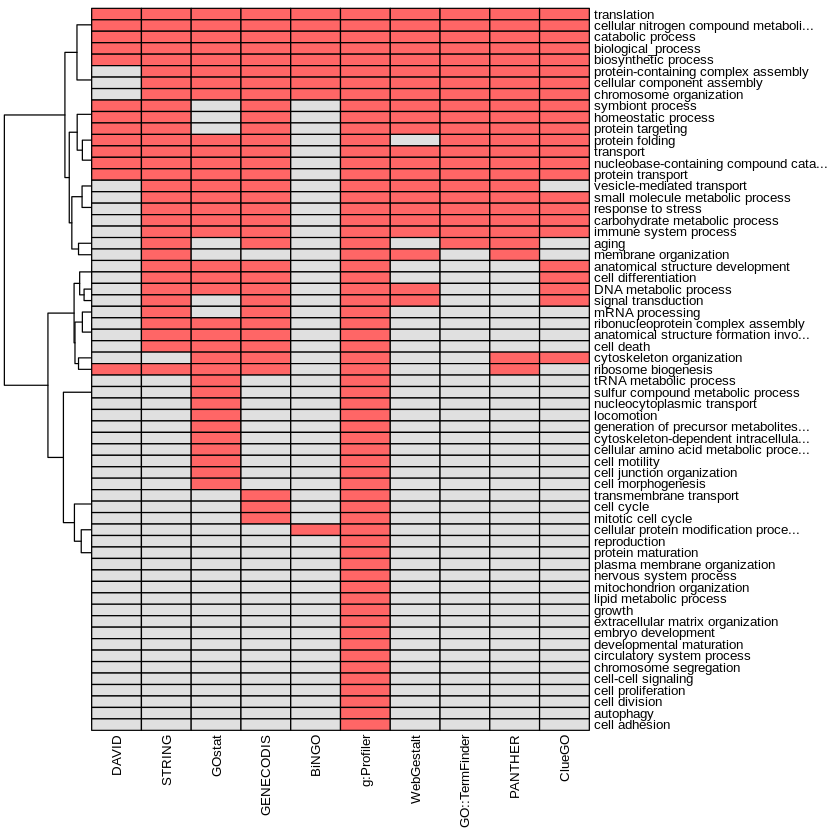

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "BP") %>% filter(Dataset == "EGCG") %>% plot_bin()

##### MF

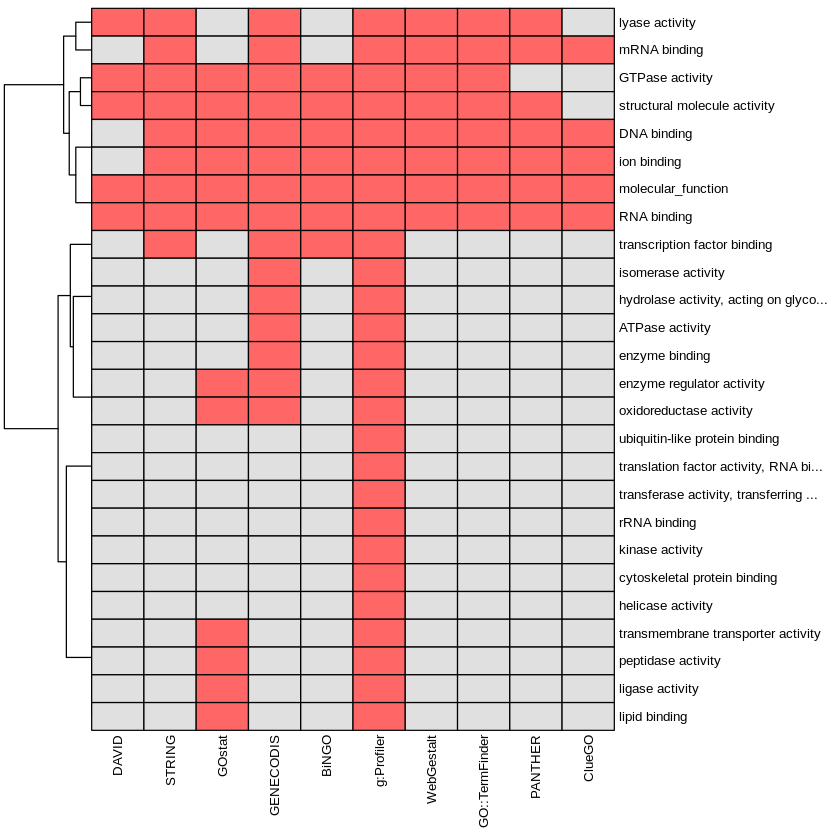

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "MF") %>% filter(Dataset == "EGCG") %>% plot_bin()

##### CC

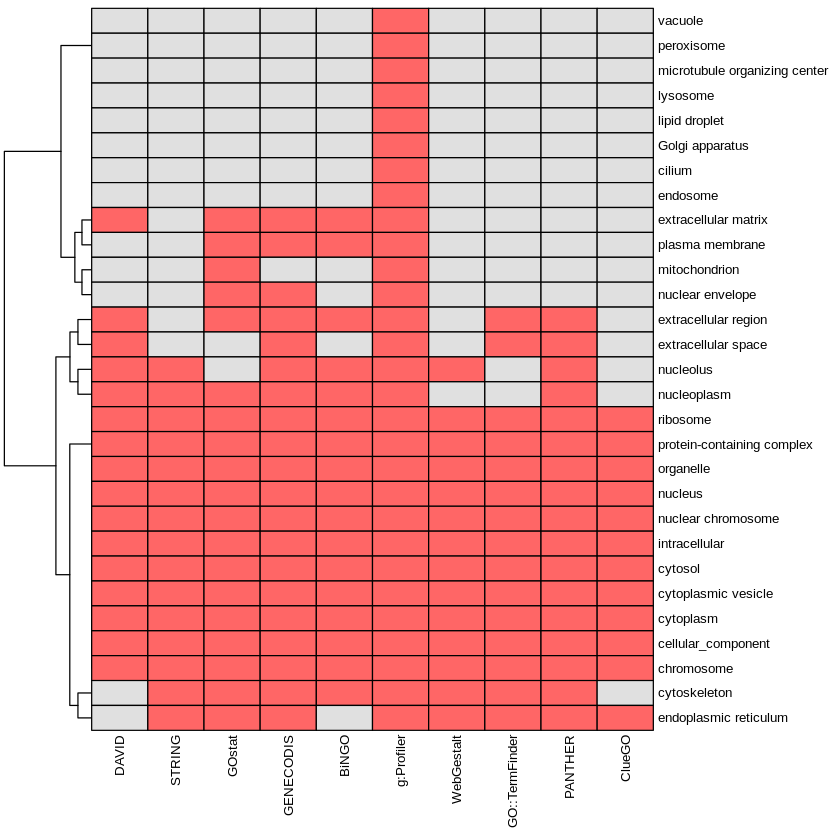

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "CC") %>% filter(Dataset == "EGCG") %>% plot_bin()

#### Caffeine Dataset

##### BP

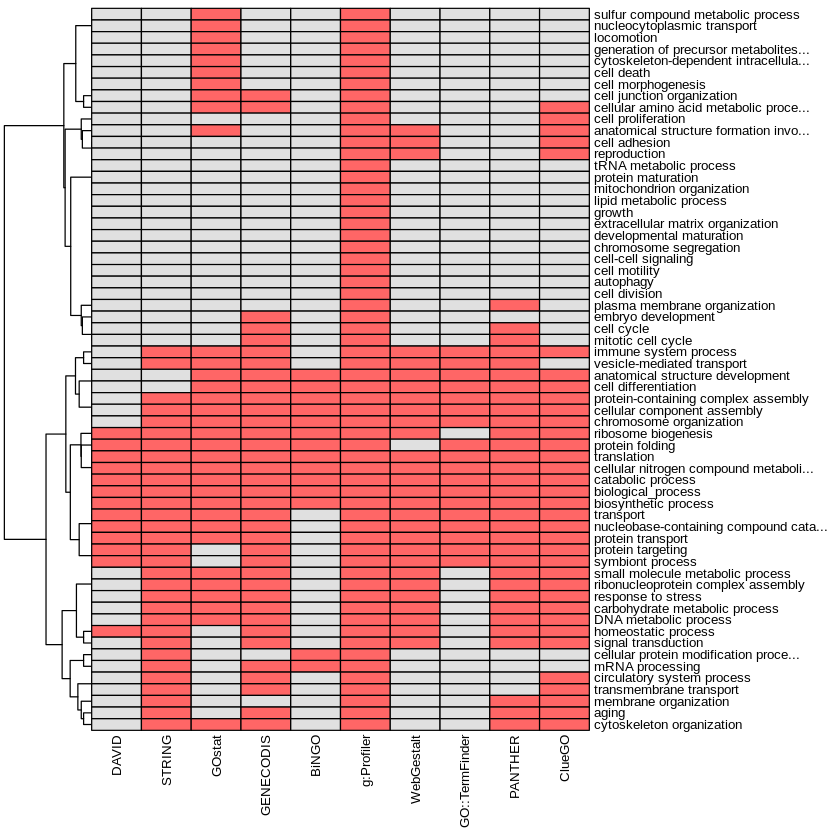

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "BP") %>% filter(Dataset == "Caffeine") %>% plot_bin()

##### MF

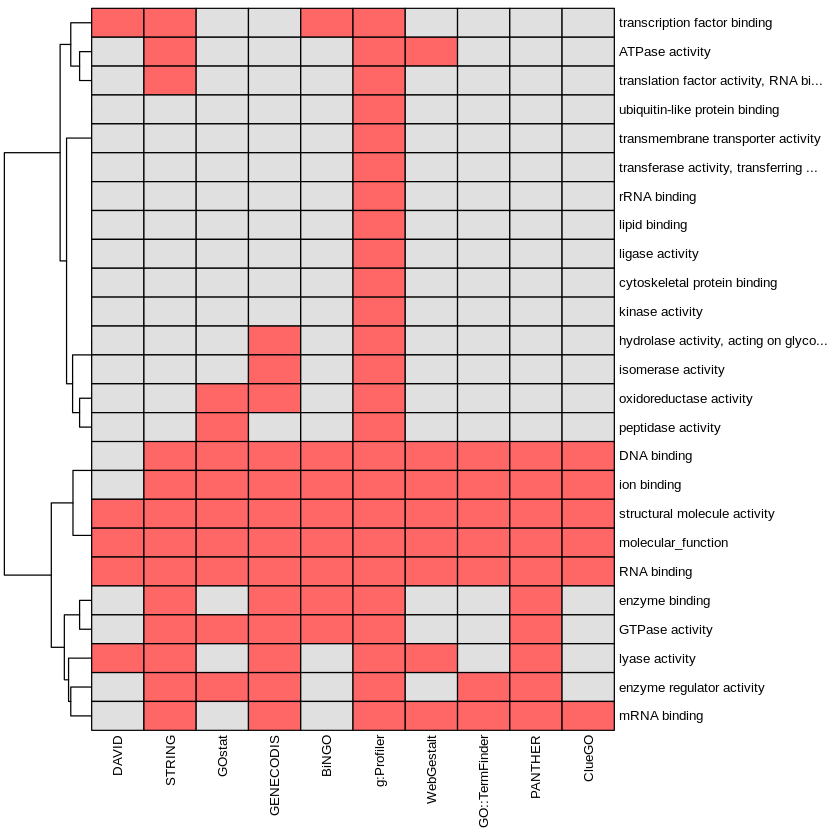

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "MF") %>% filter(Dataset == "Caffeine") %>% plot_bin()

##### CC

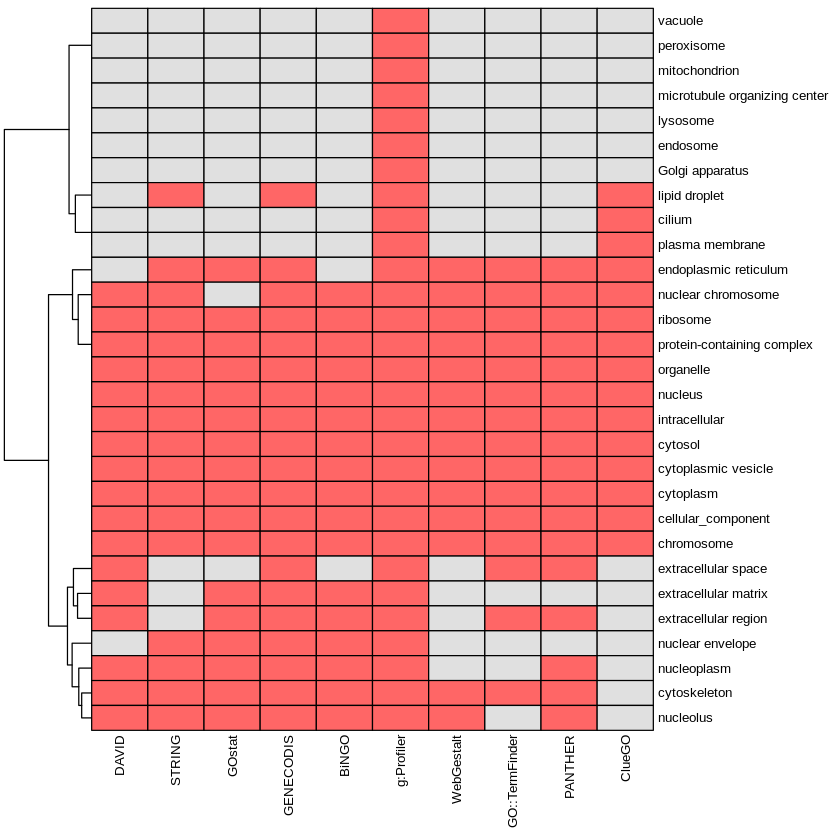

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "CC") %>% filter(Dataset == "Caffeine") %>% plot_bin()

### Present tools vs Prevously Found

#### EGCG *Dataset*

##### BP

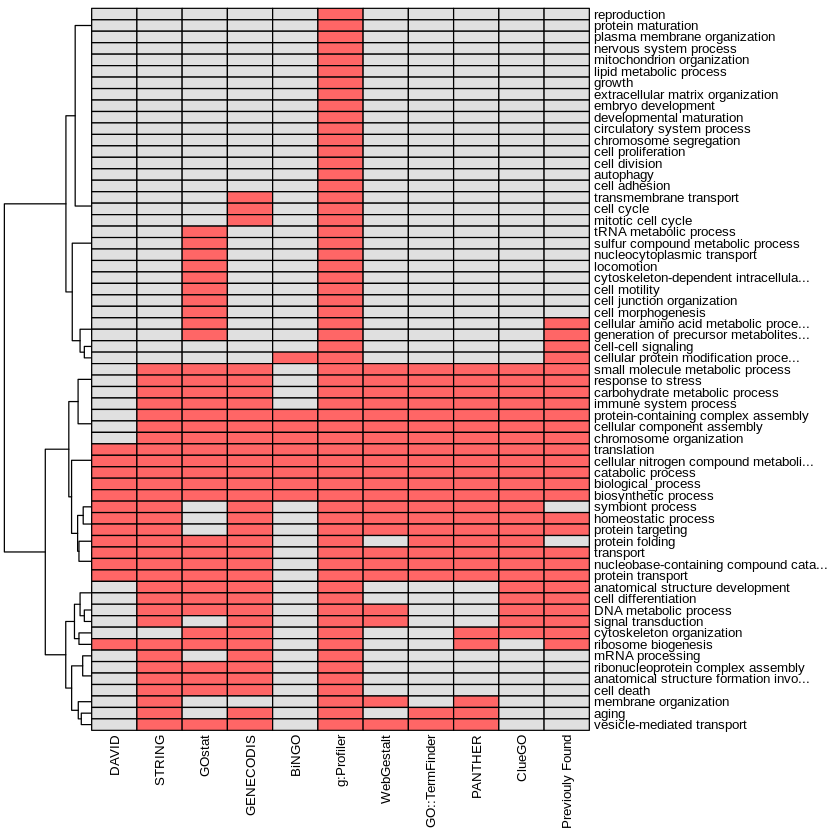

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "BP") %>% filter(Dataset == "EGCG") %>% plot_bin_02()

##### MF

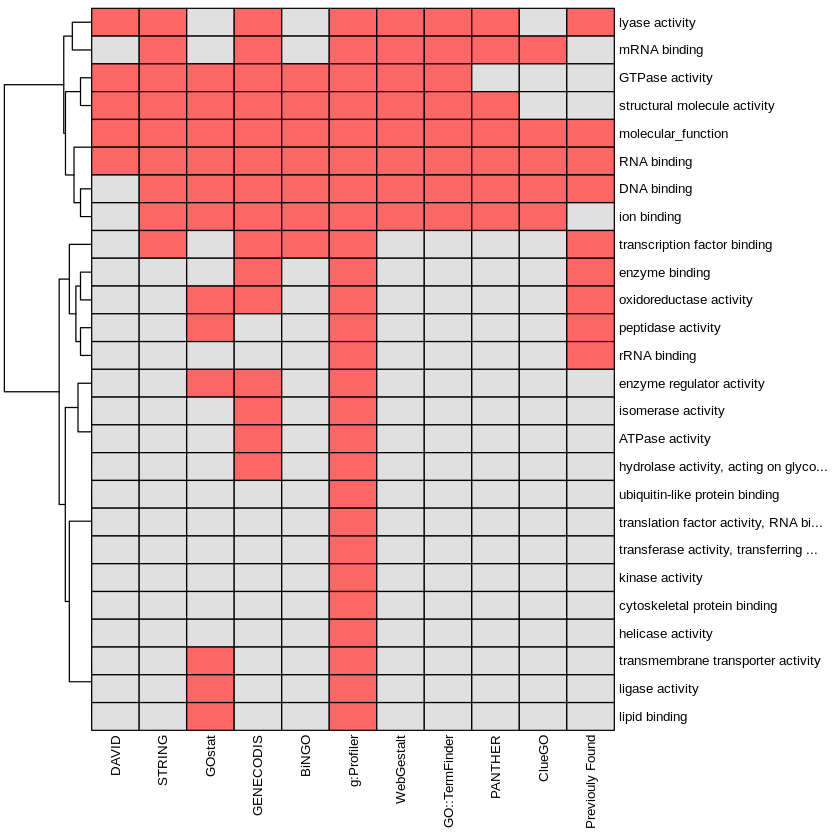

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "MF") %>% filter(Dataset == "EGCG") %>% plot_bin_02()

#### Caffeine Dataset

##### BP

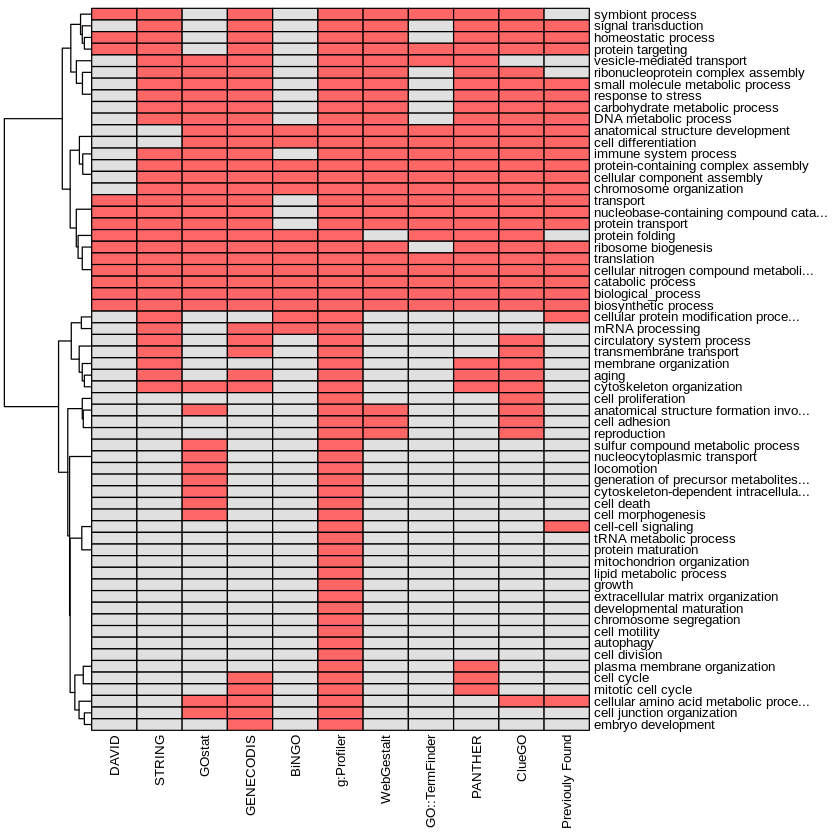

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "BP") %>% filter(Dataset == "Caffeine") %>% plot_bin_02()

##### MF

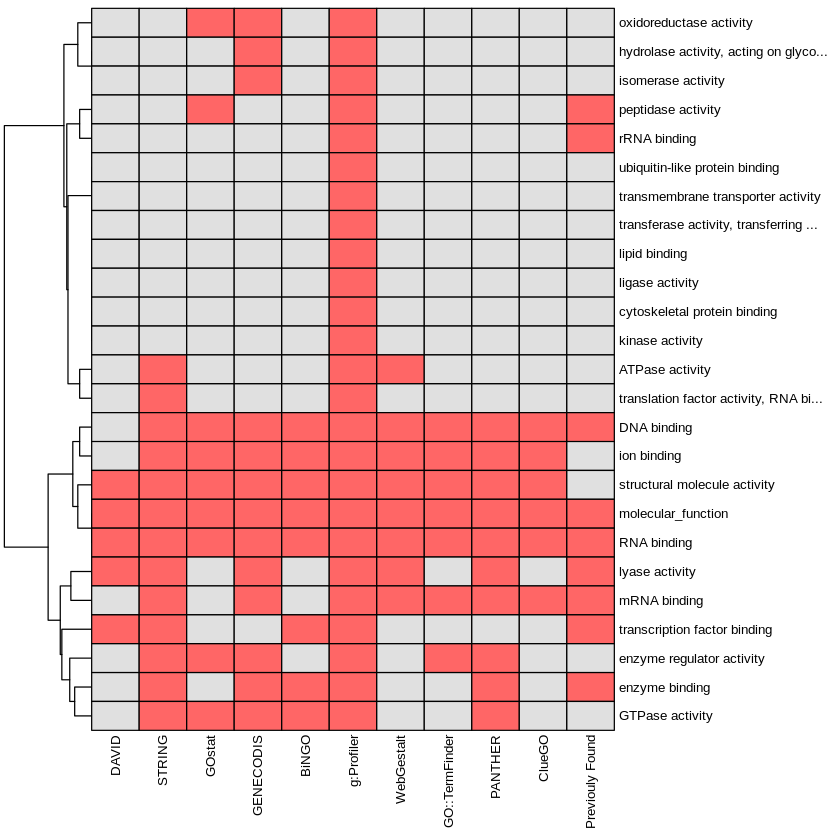

In [ ]:
fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/biological_compare.csv") %>% filter(Type == "MF") %>% filter(Dataset == "Caffeine") %>% plot_bin_02()

# **The Information content of Identified GO terms**

In [339]:
all_IC <- fread("https://raw.githubusercontent.com/kittisaktaoma/GO-tools-comparsion/master/res/Enrichment_01.txt") %>% dplyr::select(-gene) %>% unique() 
head(all_IC)

id,fdr,ref,des,type,dataset,database,condition
<chr>,<dbl>,<int>,<chr>,<chr>,<chr>,<chr>,<chr>
GO:0008426,0.00475653,18483,protein kinase C inhibitor activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
GO:0004347,0.04792210,18483,glucose-6-phosphate isomerase activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
GO:0061656,0.04792210,18483,SUMO conjugating enzyme activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
GO:0070320,0.04792210,18483,inward rectifier potassium channel inhibitor activity,Molecular Function,Caffeine Dataset,GENECODIS,Unique
GO:1904851,0.04075850,18883,positive regulation of establishment of protein localization to telomere,Biological Process,Caffeine Dataset,GENECODIS,Unique
GO:1904871,0.04265340,18883,positive regulation of protein localization to Cajal body,Biological Process,Caffeine Dataset,GENECODIS,Unique


In [340]:
P <- toTable(GOBPOFFSPRING)
names(P) <- c("child","parent")
P_count <- as.data.frame(table(P$parent))
P_count$type <- "BP"

C <- toTable(GOCCOFFSPRING)
names(C) <- c("child","parent")
C_count <- as.data.frame(table(C$parent))
C_count$type <- "CC"

M <- toTable(GOMFOFFSPRING) 
names(M) <- c("child","parent") 
M_count <- as.data.frame(table(M$parent))
M_count$type <- "MF"

ref <- rbind(M_count,C_count,P_count)


IC <- function(id,onto){
  cnt <- dplyr::filter(ref, Var1 == i) %>% dplyr::select(Freq) %>% as.numeric()
  df <- AnnotationDbi::select(GO.db, keys(GO.db, "GOID"),  columns = c("ONTOLOGY"))
  df_02 <- as.data.frame(table(df$ONTOLOGY)) %>% dplyr::filter(.,Var1 == onto) 
  all_onto <- as.numeric(df_02[,2])
  if (is.na(cnt) == T) {
    #all GO term in select ontology
    prob <- 1/all_onto
    IC <- -log2(prob)
    return(IC)
  } else {
   prob <- (cnt+1)/all_onto
    IC <- -log2(prob)
    return(IC)
  }
}

In [ ]:
list <- all_IC %>% dplyr::filter(type == "Molecular Function") %>% dplyr::select(id) %>% unlist() %>% unique() 
datalist <- list()
for (i in list) {
  res <- as.data.frame(IC(i,"MF")) 
  res$i <- i
  datalist[[i]] <- res
}

big_data_MF <- do.call(rbind,datalist) %>% as.data.frame() %>% setnames("i","id")
names(big_data_MF) <- c("IC","id")


In [ ]:
list <- all_IC %>% dplyr::filter(type == "Cellular Component") %>% dplyr::select(id) %>% unlist() %>% unique() 
datalist <- list()
for (i in list) {
  res <- as.data.frame(IC(i,"CC")) 
  res$i <- i
  datalist[[i]] <- res
}

big_data_CC <- do.call(rbind,datalist) %>% as.data.frame() %>% setnames("i","id")  
names(big_data_CC) <- c("IC","id")

In [ ]:
list <- all_IC %>% dplyr::filter(type == "Biological Process") %>% dplyr::select(id) %>% unlist() %>% unique() 
datalist <- list()
for (i in list) {
  res <- as.data.frame(IC(i,"BP")) 
  res$i <- i
  datalist[[i]] <- res
}

big_data_BP <- do.call(rbind,datalist) %>% as.data.frame() %>% setnames("i","id")
names(big_data_BP) <- c("IC","id")

In [354]:
names(big_data_BP) <- c("IC","id")
names(big_data_CC) <- c("IC","id")
names(big_data_MF) <- c("IC","id")
IC <- rbind(big_data_BP,big_data_CC,big_data_MF) %>% setnames(c("IC","id"),c("IC","id"))

merge_01 <- inner_join(all_IC,IC,by= "id")
merge_01$IC <- as.numeric(merge_01$IC)
merge_02 <- merge_01 %>% setnames("IC","Information_Content")

merge_EGCG <- merge_02 %>%
  group_by(database,type,dataset) %>% 
  dplyr::summarize(median(Information_Content)) %>% 
  as.data.frame() %>% 
  filter(.,dataset == "EGCG Dataset")

merge_Caffeine <- merge_02  %>%
  group_by(database,type,dataset) %>% 
  dplyr::summarize(median(Information_Content)) %>% 
  as.data.frame() %>% 
  filter(.,dataset == "Caffeine Dataset")

`summarise()` regrouping output by 'database', 'type' (override with `.groups` argument)

`summarise()` regrouping output by 'database', 'type' (override with `.groups` argument)



In [361]:
EGCG_cor <- reshape(merge_EGCG[,-3],idvar = c("database"),timevar = "type",direction = "wide")
names(EGCG_cor) <- c("database",
              "Biological Process",
              "Cellular Component",
              "Molecular Function")
      
EGCG_cor.01 <- EGCG_cor[,-1]
rownames(EGCG_cor.01) <- EGCG_cor[,1]
EGCG_cor.01$BP <- scale(EGCG_cor.01$`Biological Process`)
EGCG_cor.01$MF <- scale(EGCG_cor.01$`Molecular Function`)
EGCG_cor.01$CC <- scale(EGCG_cor.01$`Cellular Component`)

EGCG_cor.02 <- EGCG_cor.01[,-c(1:3)]

row_dend = hclust(dist(EGCG_cor.02),method = "complete") # row clustering
col_dend = hclust(dist(t(EGCG_cor.02)),method = "complete") # column clustering

#row.names(EGCG_cor.02) <- factor(row.names(EGCG_cor.02), levels=c("PANTHER","g:Profiler","GO::TermFinder",
#                                                    "BiNGO","GOstat","STRING","ClueGO",
#                                                    "GENECODIS","DAVID","WebGestalt"))


,BP,MF,CC
,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
BiNGO,0.52656976,-0.5607155,-0.6563373
ClueGO,1.25896332,1.6396723,1.6981249
DAVID,-0.53631639,-0.6941867,-1.3259457
g:Profiler,-1.21464619,-0.9847969,-0.3960844
GENECODIS,1.90486831,1.6396723,1.6981249
GO::TERMFINDER,-1.18337373,-0.6316330,-0.4281933
GOstat,-0.25968753,0.9034217,-0.2889033
PANTHER,-0.06612645,-0.6316330,-0.4138376
STRING,-0.51634808,-0.2635077,-0.4138376


In [362]:
#EGCG
col_fun = colorRamp2(c(-2, 0, 2), c("blue", "white", "red"))
col_fun(seq(-2, 2))

EGCG_cor <- reshape(merge_EGCG[,-3],idvar = c("database"),timevar = "type",direction = "wide")
names(EGCG_cor) <- c("database",
              "Biological Process",
              "Cellular Component",
              "Molecular Function")
      
EGCG_cor.01 <- EGCG_cor[,-1]
rownames(EGCG_cor.01) <- EGCG_cor[,1]
summary(EGCG_cor.01)
EGCG_cor.01$BP <- scale(EGCG_cor.01$`Biological Process`)
EGCG_cor.01$MF <- scale(EGCG_cor.01$`Molecular Function`)
EGCG_cor.01$CC <- scale(EGCG_cor.01$`Cellular Component`)

EGCG_cor.02 <- EGCG_cor.01[,-c(1:3)]

row_dend = hclust(dist(EGCG_cor.02),method = "complete") # row clustering
col_dend = hclust(dist(t(EGCG_cor.02)),method = "complete") # column clustering

options(repr.plot.width=10, repr.plot.height=8)
col_fun = colorRamp2(c(-2, 0, 2), c("blue", "white", "red"))
#col_fun(seq(-2, 2))

Heatmap(EGCG_cor.02,col=col_fun, name = "IC standardized Median", 
        row_names_gp = gpar(fontsize = 13),
        heatmap_legend_param = list(
          legend_height = unit(4, "cm"),
          grid_width = unit(0.5, "cm"),
         title_gp = gpar(fontsize = 13),
         labels_gp = gpar(fontsize = 13)),
        row_dend_width = unit(3, "cm"), 
       cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2f", EGCG_cor.02[i, j]), x, y, gp = gpar(fontsize = 13))
        }, clustering_method_rows = "average",
        cluster_columns = FALSE)


[1] "#0000FFFF" "#B38BFFFF" "#FFFFFFFF" "#FF9E81FF" "#FF0000FF"

 Biological Process Cellular Component Molecular Function
 Min.   : 6.302     Min.   : 5.628     Min.   : 9.88     
 1st Qu.: 7.610     1st Qu.: 7.065     1st Qu.:10.36     
 Median : 8.315     Median : 7.097     Median :10.55     
 Mean   : 8.627     Mean   : 7.743     Mean   :11.22     
 3rd Qu.: 9.424     3rd Qu.: 8.258     3rd Qu.:12.05     
 Max.   :12.273     Max.   :10.452     Max.   :13.44     

ERROR: ignored

In [ ]:
EGCG_cor.02

,BP,MF,CC
,"<dbl[,1]>","<dbl[,1]>","<dbl[,1]>"
BiNGO,-0.53128754,-1.5065944,-1.1396835
ClueGO,1.59944877,0.7897506,1.5790120
DAVID,0.84383563,1.0643148,0.1300904
g:Profiler,0.23315764,0.1259580,0.3307330
GENECODIS,1.43978799,1.4535432,1.4197531
GO::TermFinder,-0.88030971,-0.8428019,-0.1088798
GOstat,-0.75874576,0.7897506,-1.1396835
PANTHER,-1.12622986,-1.0737508,-0.2914792
STRING,-0.83710703,-0.2623357,-1.2163845


In [ ]:
#Caffeine
Caf_cor <- reshape(merge_Caffeine[,-3],idvar = c("Database"),timevar = "Type",direction = "wide")
names(Caf_cor) <- c("database",
              "Biological Process",
              "Cellular Component",
              "Molecular Function")
Caf_cor.01 <- Caf_cor[,-1]
rownames(Caf_cor.01) <- Caf_cor[,1]
head(merge_02)
summary(Caf_cor.01)
Caf_cor.01$BP <- scale(Caf_cor.01$`Biological Process`)
Caf_cor.01$MF <- scale(Caf_cor.01$`Molecular Function`)
Caf_cor.01$CC <- scale(Caf_cor.01$`Cellular Component`)

Caf_cor.02 <- Caf_cor.01[,-c(1:3)]

row_dend = hclust(dist(Caf_cor.02),method = "complete") # row clustering
col_dend = hclust(dist(t(Caf_cor.02)),method = "complete") # column clustering

row.names(Caf_cor.02) <- factor(row.names(Caf_cor.02), levels=c("PANTHER","g:Profiler","GO::TermFinder",
                                                    "BiNGO","GOstat","STRING","ClueGO",
                                                    "GENECODIS","DAVID","WebGestalt"))

Heatmap(Caf_cor.02,col=col_fun, name = "IC standardized Median", 
        row_names_gp = gpar(fontsize = 13),
        heatmap_legend_param = list(
          legend_height = unit(4, "cm"),
          grid_width = unit(0.5, "cm"),
         title_gp = gpar(fontsize = 13),
         labels_gp = gpar(fontsize = 13)),
        row_dend_width = unit(3, "cm"),
       cluster_columns = FALSE, 
       cell_fun = function(j, i, x, y, width, height, fill) {
          grid.text(sprintf("%.2f", Caf_cor.02[i, j]), x, y, gp = gpar(fontsize = 13))
        }, clustering_method_rows = "average")

In [ ]:
#Within Dataset
within_IC <- merge_02[,-c(2,3,6,9)]
within_IC_index <- merge_02[,-c(1,2,3,4,6,8,9)] %>% unique()
head(within_IC_index)
head(within_IC)

Type,Dataset
<chr>,<chr>
MF,EGCG
BP,EGCG
CC,EGCG
BP,Caffeine
CC,Caffeine
MF,Caffeine


GOID,Database,Type,Dataset,Information_Content
<chr>,<chr>,<chr>,<chr>,<dbl>
GO:0008301,STRING,MF,EGCG,11.122569
GO:0005544,GOstat,MF,EGCG,13.444497
GO:0035986,GO::TermFinder,BP,EGCG,14.858127
GO:0042886,GO::TermFinder,BP,EGCG,5.646238
GO:0030163,g:Profiler,BP,EGCG,7.688202
GO:0050920,g:Profiler,BP,EGCG,7.963309


In [ ]:
datalist <- list()
for (i in 1:nrow(within_IC_index)) {
all.test.01 <- within_IC %>% filter(.,Type == within_IC_index[i,1] %>% unlist(),
                                      Dataset == within_IC_index[i,2] %>% unlist())
head(all.test.01)
res.aov <- aov(Information_Content ~ Database, data = all.test.01)
model=lm( all.test.01$Information_Content ~ all.test.01$Database )
     ANOVA=aov(model)
TUKEY <- TukeyHSD(x=ANOVA, 'all.test.01$Database', conf.level=0.95) 
TUKEY.02 <- TUKEY$`all.test.01$Database` %>% as.data.frame() %>% select(-diff,-lwr,-upr)
TUKEY.03 <- t(TUKEY.02) %>% as.data.frame()
rownames(TUKEY.03) <- NULL
res <- cbind(tidy(res.aov)[-2,],TUKEY.03)[,-c(1,2,3,4)]
res$Type <- within_IC_index[i,1] %>% unlist()
res$Dataset <-within_IC_index[i,2] %>% unlist()
datalist[[i]] <- res
}

res.01 <- do.call(rbind,datalist) %>% unique()
print(res.01)



In [ ]:
#Between Dataset
tool_list <- merge_02$Database %>% unique()
p_value <- list()
for (i in tool_list) {
  print(i)
  x <- merge_02 %>% filter(Database == i, Type == "MF")
  res <- t.test(Information_Content ~ Dataset, data = x, var.equal = TRUE)
  #print(res$p.value)
  #print(res$statistic)
  p_value[i] <- res$p.value
}

[1] "STRING"
[1] "GOstat"
[1] "GO::TermFinder"
[1] "g:Profiler"
[1] "GENECODIS"
[1] "BiNGO"
[1] "PANTHER"
[1] "WebGestalt"
[1] "DAVID"
[1] "ClueGO"


In [ ]:
res_p <- p.adjust(p_value,method="bonferroni") 
res_p %>% as.data.frame()

,.
,<dbl>
STRING,1
GOstat,1
GO::TermFinder,1
g:Profiler,1
GENECODIS,1
BiNGO,1
PANTHER,1
WebGestalt,1
DAVID,1


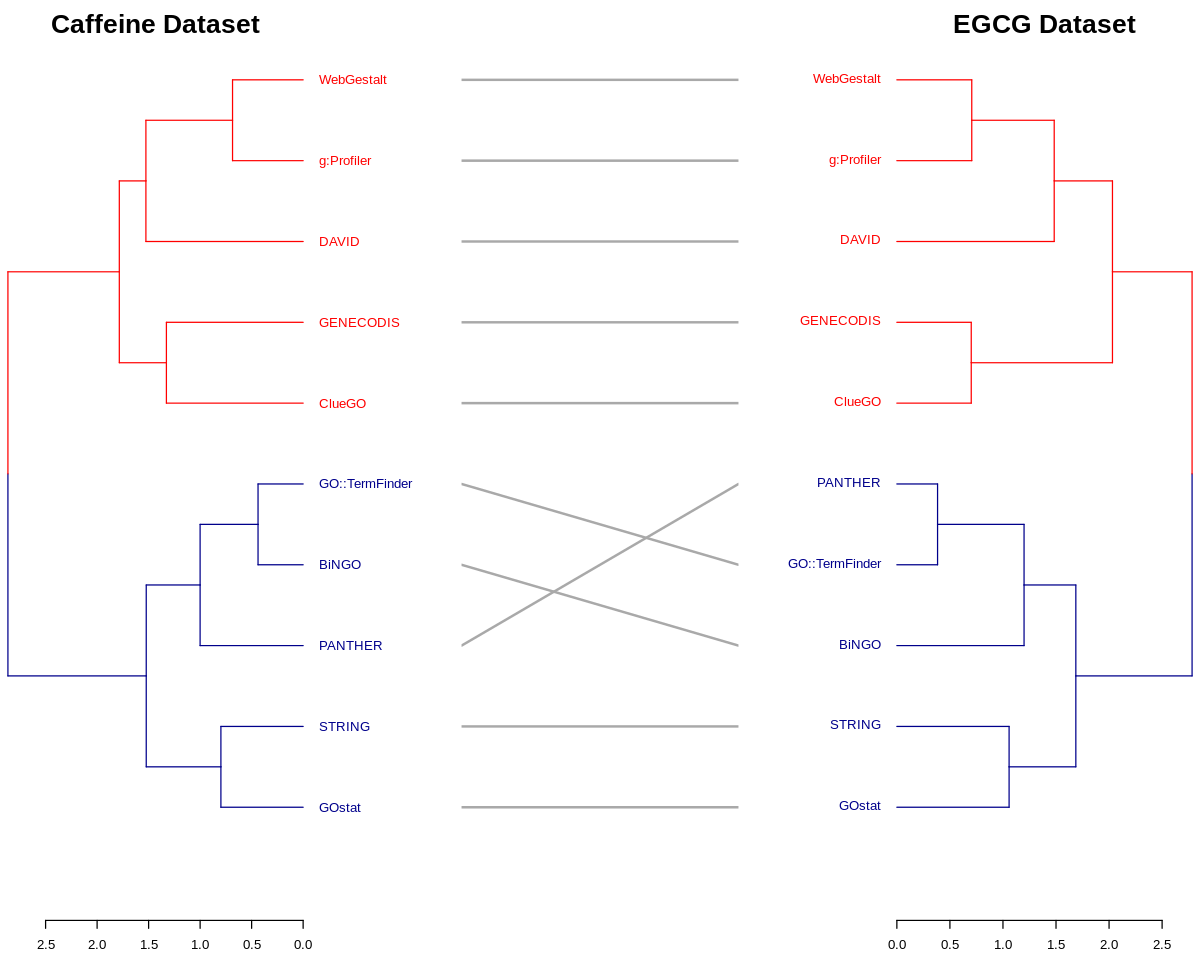

In [ ]:
d1 <- Caf_cor.02 %>% dist() %>% hclust( method="average" ) %>% as.dendrogram()
d2 <- EGCG_cor.02 %>% dist() %>% hclust( method="average" ) %>% as.dendrogram()

# Custom these kendo, and place them in a list
dl <- dendlist(
  d1 %>% 
    set("labels_col", value = c("darkblue", "red"), k=2) %>%
    set("branches_lty", 1) %>%
    set("branches_k_color", value = c("darkblue", "red"), k = 2),
  d2 %>% 
    set("labels_col", value = c("darkblue", "red"), k=2) %>%
    set("branches_lty", 1) %>%
    set("branches_k_color", value = c("darkblue", "red"), k = 2)
)

# Plot them together
tanglegram(dl, 
           common_subtrees_color_lines = FALSE, highlight_distinct_edges  = FALSE, highlight_branches_lwd=FALSE, 
           margin_inner=10,
           lwd=2,
   main_left = "Caffeine Dataset",
   main_right = "EGCG Dataset"
)


# **Rank difference and p-value distribution of identified GO terms**

## One-way ANOVA test

`summarise()` regrouping output by 'type', 'dataset' (override with `.groups` argument)



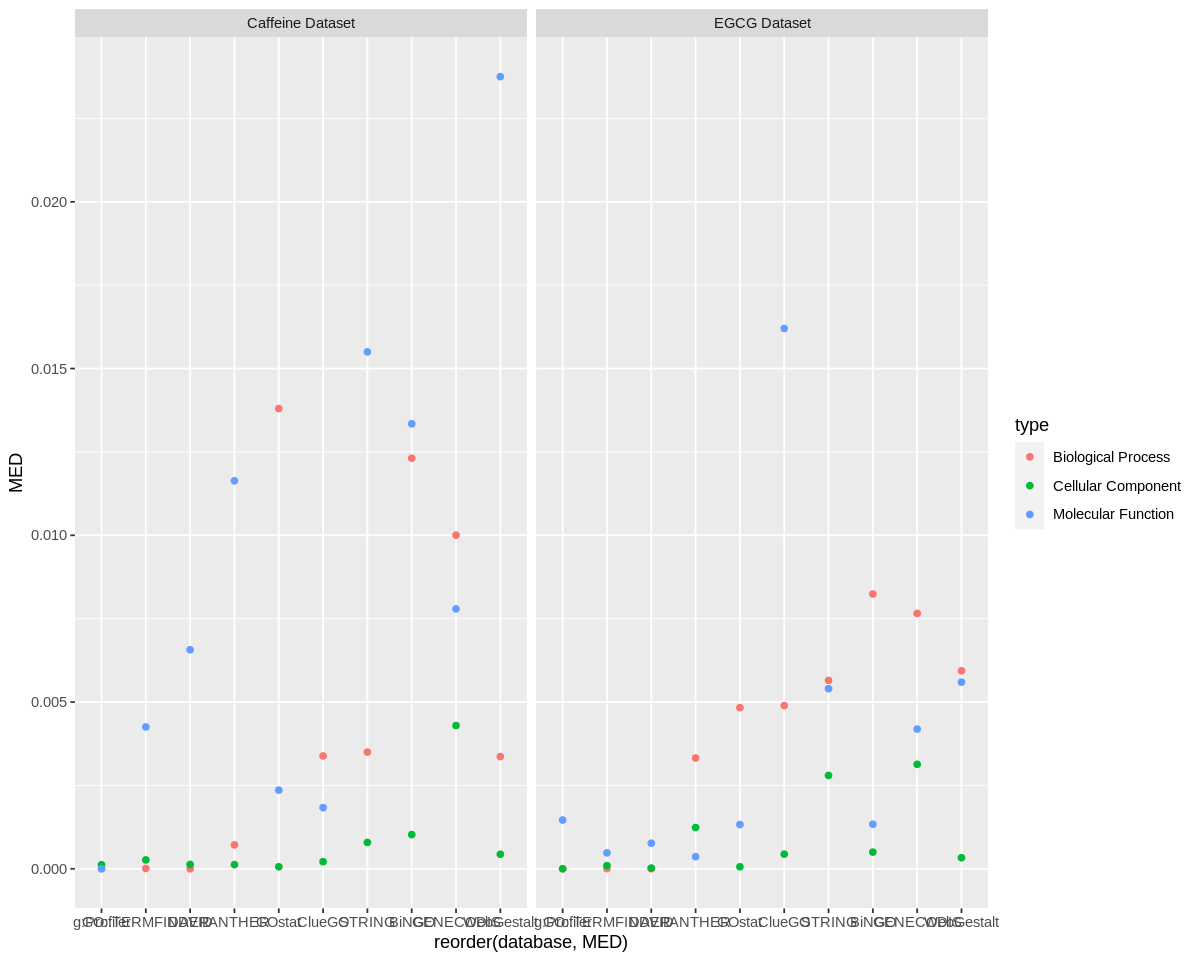

In [383]:
df_01[,c(3,6,7,8)] %>% unique() %>% group_by(type,dataset,database) %>% summarise(MED=median(fdr)) %>% 
ggplot(aes(reorder(database,MED),MED,color=type)) +
geom_point() +
facet_grid(cols=vars(dataset))

### F-test plus Pairwise

In [ ]:
Caffeine.test <- all[,-c(2,6)] %>% filter(.,Dataset == "Caffeine") %>% unique() 
EGCG.test <- all[,-c(2,6)] %>% filter(.,Dataset == "EGCG") %>% unique()

all.test <- rbind(Caffeine.test,EGCG.test)[,-c(1,2)] %>% unique()
head(all.test)
all.test.99 <- rbind(Caffeine.test,EGCG.test)
head(all.test.99)

In [ ]:
datalist <- list()
for (i in 1:nrow(all.test)) {
all.test.01 <- all.test.99 %>% filter(.,Type == all.test[i,2] %>% unlist(),
                                            Dataset == all.test[i,3] %>% unlist())
res.aov <- kruskal.test(FDR ~ Database, data = all.test.01)
res.1 <- tidy(res.aov)
res.1$Type <- all.test[i,2] %>% unlist()
res.1$Dataset <-all.test[i,3] %>% unlist()

PT = dunnTest(FDR ~ Database,
              data=all.test.01,
              method="bh")    # Can adjust p-values;
                              # See ?p.adjust for options

PT.02 <- PT$res %>% select(Comparison,P.adj) %>% as.data.frame() 
PT.03 <- PT.02 
rownames(PT.03) <- PT.02[,1]
PT.04 <- t(PT.03) %>% as.data.frame()
rownames(PT.04) <- NULL
res <- cbind(res.1,PT.04[-1,])
datalist[[i]] <- res
}
res.01 <- do.call(rbind,datalist) %>% unique()
head(res.01)

Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a factor.”
Warning message:
“Database was coerced to a fa

,statistic,p.value,parameter,method,Type,Dataset,BiNGO - ClueGO,BiNGO - DAVID,ClueGO - DAVID,BiNGO - g:Profiler,⋯,PANTHER - STRING,BiNGO - WebGestalt,ClueGO - WebGestalt,DAVID - WebGestalt,g:Profiler - WebGestalt,GENECODIS - WebGestalt,GO::TermFinder - WebGestalt,GOstat - WebGestalt,PANTHER - WebGestalt,STRING - WebGestalt
,<dbl>,<dbl>,<int>,<chr>,<chr>,<chr>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
2,143.12393,2.334728e-26,9,Kruskal-Wallis rank sum test,BP,Caffeine,2.698058e-06,6.204241e-04,2.356570e-01,3.278085e-03,⋯,2.421063e-02,2.783100e-03,2.105739e-02,3.021738e-02,4.047591e-01,4.784307e-04,2.540653e-06,2.480061e-06,2.815844e-01,3.320489e-01
21,28.97709,6.538312e-04,9,Kruskal-Wallis rank sum test,CC,Caffeine,0.039376979,0.803519686,0.157525799,0.836996163,⋯,0.526373475,0.973992895,0.039609926,0.824639487,0.811862382,0.102786977,0.277056030,0.819451270,0.578919488,0.977099781
22,30.70650,3.323737e-04,9,Kruskal-Wallis rank sum test,MF,Caffeine,0.0216446465,0.6648384703,0.1999058993,0.3391866274,⋯,0.1630691988,0.7763051228,0.0076444769,0.4821479703,0.1633693614,0.6798469783,0.1703099741,0.4171721558,0.2007313847,0.8960195313
230,32.21779,1.825817e-04,9,Kruskal-Wallis rank sum test,MF,EGCG,0.013705730,0.250181278,0.255828328,0.169130005,⋯,0.549071129,0.444537287,0.068442546,0.587565920,0.795181327,0.149541528,0.606239905,0.369254068,0.380069424,0.738823636
232,146.97746,3.726237e-27,9,Kruskal-Wallis rank sum test,BP,EGCG,2.543185e-07,4.301470e-02,5.129196e-01,7.540725e-01,⋯,4.587024e-02,2.534751e-01,2.386549e-06,1.389181e-01,1.579880e-01,2.084266e-01,1.524234e-01,1.006362e-10,7.713542e-01,1.705377e-01
235,35.68945,4.500507e-05,9,Kruskal-Wallis rank sum test,CC,EGCG,1.345048e-03,1.354591e-01,1.866627e-01,1.923398e-01,⋯,5.477790e-01,6.620061e-01,5.233000e-03,2.770718e-01,6.665795e-01,1.815763e-01,1.969761e-01,8.657466e-01,3.437910e-01,6.705538e-01


### Display Mean

In [ ]:
me.tools <- all %>% group_by(Dataset,Database,Type) %>% dplyr::summarise(me=median(FDR),sd=sd(FDR)) %>% as.data.frame()
me.tools <- me.tools[order(me.tools$me,me.tools$sd),]
me.tools[,c(4,5)] <- round(me.tools[,c(4,5)], 8)
me.tools[,5] <- round(me.tools[,5], 4)
me.tools[,c(4,5)] <- format(me.tools[,c(4,5)], scientific = T)
me.tools$sumstat <- paste0(me.tools$me," ","(",me.tools$sd,")")

res.me <- reshape(me.tools[,-c(4,5)],idvar = c("Dataset","Type"),timevar = "Database",direction = "wide")
head(res.me)

`summarise()` regrouping output by 'Dataset', 'Database' (override with `.groups` argument)



,Dataset,Type,sumstat.DAVID,sumstat.ClueGO,sumstat.GO::TermFinder,sumstat.PANTHER,sumstat.WebGestalt,sumstat.GOstat,sumstat.STRING,sumstat.BiNGO,sumstat.g:Profiler,sumstat.GENECODIS
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
7,Caffeine,BP,6.0000e-08 (5.80e-03),1.4300e-03 (3.60e-03),7.4800e-06 (5.20e-03),7.3300e-04 (1.36e-02),3.8100e-03 (1.40e-02),1.7700e-02 (1.38e-02),7.3000e-03 (1.46e-02),1.2300e-02 (1.44e-02),3.4200e-03 (1.54e-02),1.6850e-02 (1.67e-02)
37,EGCG,BP,4.2000e-07 (1.30e-02),2.7700e-04 (8.00e-04),8.8500e-04 (1.45e-02),6.3100e-03 (1.40e-02),6.5700e-03 (1.49e-02),3.3700e-02 (1.47e-02),1.5100e-02 (1.33e-02),9.2950e-03 (1.43e-02),1.0700e-02 (1.57e-02),1.4400e-02 (1.47e-02)
36,EGCG,MF,1.0700e-02 (1.30e-02),2.1400e-06 (1.00e-04),1.2100e-02 (1.15e-02),3.1400e-02 (1.66e-02),1.5500e-02 (1.20e-02),1.2350e-02 (1.86e-02),8.1000e-03 (1.69e-02),2.5400e-02 (1.71e-02),8.6100e-03 (1.43e-02),2.9300e-02 (1.60e-02)
5,Caffeine,CC,1.3150e-04 (1.50e-02),1.3370e-05 (1.10e-03),3.3600e-04 (9.40e-03),1.2645e-04 (1.12e-02),2.9400e-04 (1.15e-02),4.1900e-04 (1.48e-02),9.2000e-04 (8.40e-03),1.0350e-03 (1.28e-02),1.9300e-03 (1.54e-02),4.6000e-03 (1.68e-02)
35,EGCG,CC,3.6750e-04 (1.10e-02),1.5950e-05 (5.00e-04),1.1800e-03 (1.20e-02),2.4000e-03 (1.22e-02),4.6500e-03 (1.22e-02),2.8650e-03 (1.68e-02),3.3000e-03 (9.90e-03),5.5000e-03 (1.79e-02),4.7000e-03 (1.48e-02),1.3300e-02 (1.56e-02)
6,Caffeine,MF,8.1800e-03 (1.67e-02),4.0600e-04 (3.60e-03),8.5000e-03 (1.49e-02),1.0850e-02 (1.26e-02),2.2900e-02 (1.75e-02),8.5000e-03 (1.57e-02),1.4300e-02 (1.36e-02),2.1800e-02 (1.37e-02),7.7700e-03 (1.58e-02),2.4600e-02 (1.97e-02)


## Display Plot

`summarise()` regrouping output by 'Database' (override with `.groups` argument)

`summarise()` regrouping output by 'Database' (override with `.groups` argument)



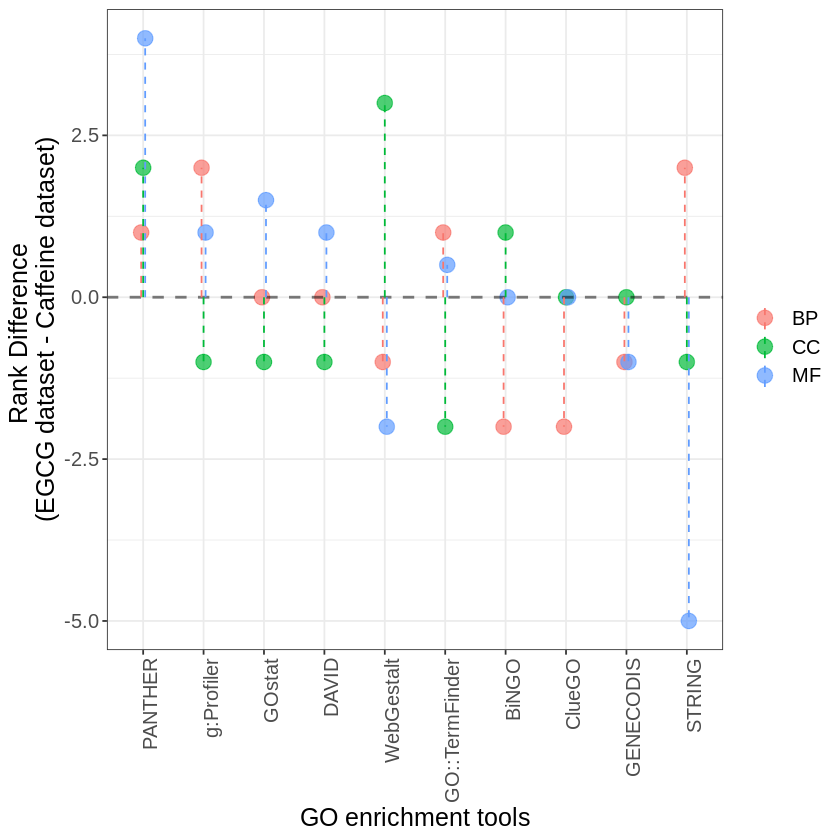

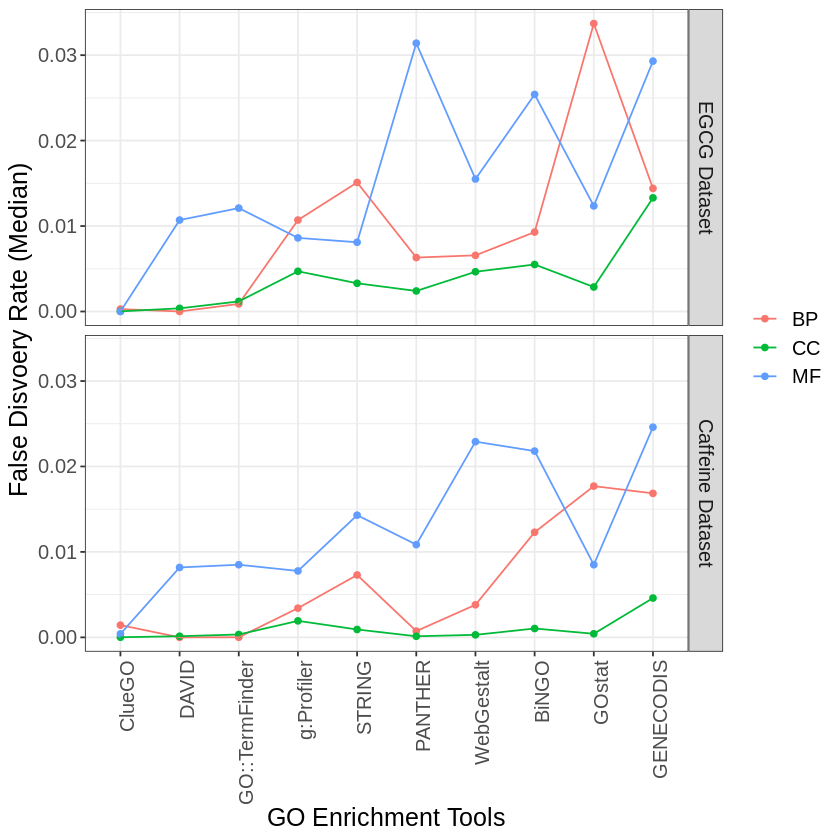

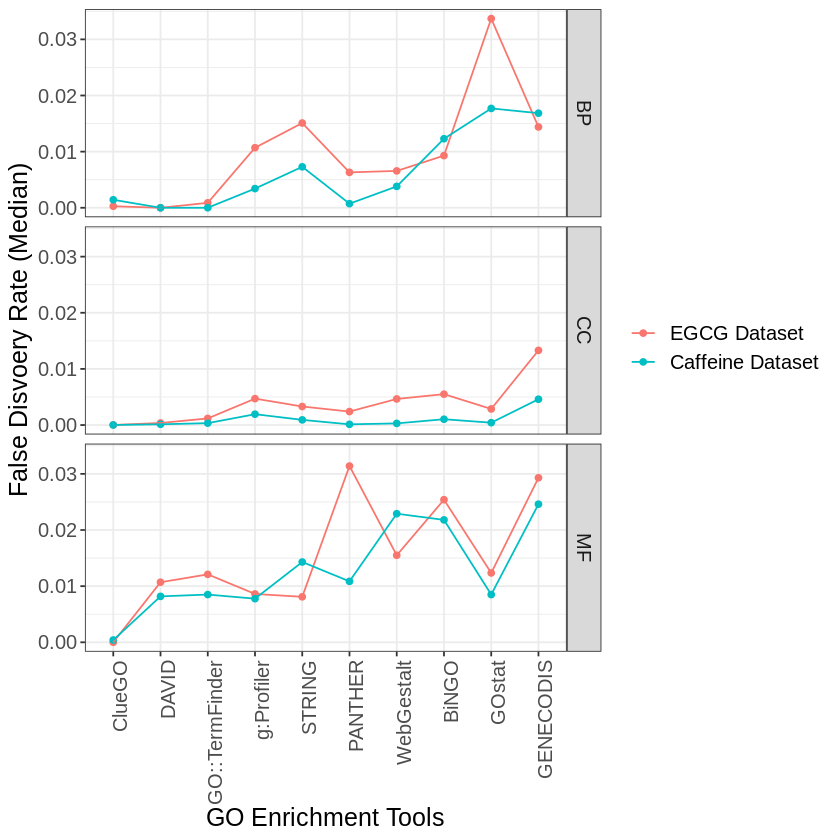

In [ ]:
Caffeine <- all  %>% filter(.,Dataset == "Caffeine") %>% unique() %>%
  group_by(Database,Type) %>% summarise(Caffeine=median(FDR)) %>% as.data.frame()

Caffeine_BP <- filter(Caffeine,Type == "BP") 
Caffeine_BP$Rank <- rank(Caffeine_BP$Caffeine)

Caffeine_CC <- filter(Caffeine,Type == "CC") 
Caffeine_CC$Rank <- rank(Caffeine_CC$Caffeine)

Caffeine_MF <- filter(Caffeine,Type == "MF") 
Caffeine_MF$Rank <- rank(Caffeine_MF$Caffeine)

aCaf <- rbind(Caffeine_BP,Caffeine_CC,Caffeine_MF)

EGCG <- all  %>% filter(.,Dataset == "EGCG") %>% unique() %>%
  group_by(Database,Type) %>% summarise(EGCG=median(FDR)) %>% as.data.frame()


EGCG_BP <- filter(EGCG,Type == "BP") 
EGCG_BP$Rank <- rank(EGCG_BP$EGCG)

EGCG_CC <- filter(EGCG,Type == "CC") 
EGCG_CC$Rank <- rank(EGCG_CC$EGCG)

EGCG_MF <- filter(EGCG,Type == "MF") 
EGCG_MF$Rank <- rank(EGCG_MF$EGCG)

aeg <- rbind(EGCG_BP,EGCG_CC,EGCG_MF)


final_all <-  cbind(aeg,aCaf)[,-c(5,6)]
names(final_all) <- c("Database","Type","EGCG","EGCG rank","Caffeine","Caffeine rank")


final_all$diff_rank <- final_all$`EGCG rank` - final_all$`Caffeine rank`

final_02 <- final_all[,-c(3:6)] %>% melt(.,id.vars = c("Database","Type")) 


ggplot(data=final_02, aes(x=reorder(Database,-value), y=value,color=Type)) +
  geom_point(aes(color=Type),size = 4,alpha = 0.7, position=position_dodge(width=0.1))+ 
  theme_bw() +
  geom_hline(yintercept=0, linetype="dashed", color = "black",size=0.8,alpha = 0.5) +
  geom_linerange(aes(x=Database,ymax=value, ymin=0),
                 linetype = "dashed",
                 size = 0.5,
                 position = position_dodge(width=0.1))+
  xlab("GO enrichment tools") +
  ylab("Rank Difference \n(EGCG dataset - Caffeine dataset)") +
  labs(color="") + 
  theme(axis.text.x = element_text(angle = 90, hjust = 1))+ 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15))

  


################ TEST #########################

df <- final_all[,-c(4,6,7)] 
names(df) <- c("database","type","EGCG Dataset","Caffeine Dataset")
df_02 <- melt(df,id.vars=c("database","type"))

ggplot(df_02,aes(x=reorder(database,value),y=value,color = type,group = type)) +
  geom_point() +
  geom_line() +
  facet_grid(vars(variable)) +
  theme_bw()+ 
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  xlab("GO Enrichment Tools") +
  ylab("False Disvoery Rate (Median)") +
  labs(color="")+ 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15))



ggplot(df_02,aes(x=reorder(database,value),y=value,color = variable,group = variable)) +
  geom_point() +
  geom_line() +
  facet_grid(rows=vars(type)) +
  theme_bw()+ 
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
  xlab("GO Enrichment Tools") +
  ylab("False Disvoery Rate (Median)") +
  labs(color="") + 
  theme(strip.text.x = element_text(size = 15))+
  theme(text = element_text(size=15))